## Traitement des données
Importation des données

In [1]:
# Importation des bibliothèques
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_pacf
from numpy.polynomial.polynomial import polyfit
from pathlib import Path
from hypothesis import strategies as st, given, settings
from sklearn.covariance import ShrunkCovariance
from sklearn.datasets import make_gaussian_quantiles
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize, LinearConstraint
from sklearn.covariance import shrunk_covariance
import yfinance as yf
import statsmodels.api as sm


In [2]:
# Récupérer le chemin d'accès du fichier
def access_path(relative_or_absolute_path: str):
    current_path = Path(os.getcwd())
    target_path = current_path / relative_or_absolute_path

    return str(target_path.resolve())

path = access_path('..\Data') # Chemin d'accès du code vers le dossier contenant les données

# Charger les données depuis les fichiers CSV
dailycrypto = pd.read_csv(os.path.join(path,"daily_crypto_data.csv"))
Mktcapvol = pd.read_csv(os.path.join(path,"market_caps_daily.csv"))
volumebinance = pd.read_csv(os.path.join(path,"volume_binance_daily.csv"))

# Extraire les données en tant qu'arrays
Mktcapvoldata = Mktcapvol.iloc[:, 1:].values
volumebinancedata = volumebinance.iloc[:, 1:].values
dailycryptodata = dailycrypto.iloc[:, 1:].values

# Charger les données à partir de Yahoo Finance pour ^IRX entre les dates spécifiées
ticker = "^IRX"
start_date = "2021-01-01"
end_date = "2023-06-29"
#13 week bill treasury 
irx_data = yf.download(ticker, start=start_date, end=end_date)

# Sélectionner la colonne "Adj Close"
adj_close = irx_data['Adj Close']

# Supprimer les lignes contenant NaN dans la colonne "Adj Close"
adj_closeRf = adj_close.dropna()

# Calculer la moyenne du taux sans risque (rendement annualisé)
Rf = adj_closeRf.mean()/100

# Afficher la moyenne du taux sans risque
print(f"Moyenne du taux sans risque : {Rf:.4}")

Récupération des rendements en continue des daily cryptos 

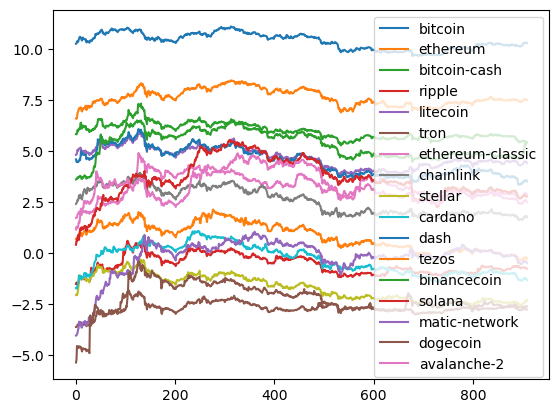

In [3]:
# Nombre de colonnes dans dailycrypto
nbcol = dailycrypto.shape[1]

# Calcul des rendements quotidiens en utilisant la différence des logarithmes
rdtdaily = np.diff(np.log(dailycryptodata), axis=0)

# Récupération du nom des colonnes
nomsColonnesString = 'bitcoin,ethereum,bitcoin-cash,ripple,litecoin,tron,ethereum-classic,chainlink,stellar,cardano,dash,tezos,binancecoin,solana,matic-network,dogecoin,avalanche-2'
cellulesNomsColonnes = nomsColonnesString.split(',')
nomsColonnes = [col.strip() for col in cellulesNomsColonnes]
#mise en forme des rendements en DataFrame
dfrdt=pd.DataFrame(rdtdaily)
dfrdt.columns=nomsColonnes
# Représentation graphique des prix en logarithme
plt.plot(np.log(dailycryptodata))
plt.legend(nomsColonnes)
plt.show()

Représentation de la distribution des rendements 

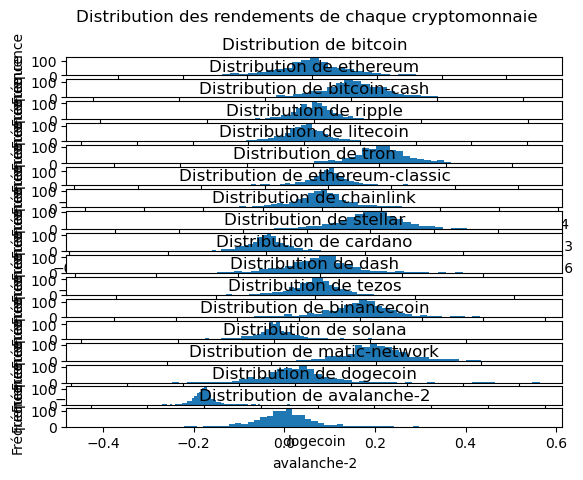

In [8]:
# Créer une nouvelle figure
plt.figure()

# Nombre total de colonnes
nbColonnes = rdtdaily.shape[1]

# Boucle pour créer les subplots
for i in range(1, nbColonnes+1):
    plt.subplot(nbColonnes, 1, i)
    
    # Afficher l'histogramme de la colonne actuelle
    plt.hist(rdtdaily[:, i-1], bins='auto')
    
    # Ajouter des étiquettes et un titre
    plt.xlabel(nomsColonnes[i-1])
    plt.ylabel('Fréquence')
    plt.title(f'Distribution de {nomsColonnes[i-1]}')

# Ajuster la disposition
plt.suptitle('Distribution des rendements de chaque cryptomonnaie')
plt.show()

Statistique sur les rendements

In [5]:
# Calcul de la kurtosis et de la skewness
kurtosisrdt_values = dfrdt.kurtosis()
skewnessrdt_values = dfrdt.skew()

# Utilisation de la méthode describe() suivie de l'ajout de kurtosis et skewness
descriptionrdt_with_kurtosis_skewness = dfrdt.describe().append(kurtosisrdt_values.rename('kurtosis')).append(skewnessrdt_values.rename('skewness'))
descriptionrdt_with_kurtosis_skewness.T

AttributeError: 'DataFrame' object has no attribute 'append'

Statistiques sur les capitalisations en log

In [ ]:
capi=pd.DataFrame(np.log(Mktcapvoldata))
capi.columns=nomsColonnes
# Calcul de la kurtosis et de la skewness
kurtosiscapi_values = capi.kurtosis()
skewnesscapi_values = capi.skew()

# Utilisation de la méthode describe() suivie de l'ajout de kurtosis et skewness
descriptioncapi_with_kurtosis_skewness =capi.describe().append(kurtosiscapi_values.rename('kurtosis')).append(skewnesscapi_values.rename('skewness'))
descriptioncapi_with_kurtosis_skewness.T

bitcoin    ethereum  bitcoin-cash      ripple    litecoin  \
count     909.000000  909.000000    909.000000  909.000000  909.000000   
mean        0.000040    0.000997     -0.000463    0.000820   -0.000447   
std         0.036000    0.047195      0.054932    0.057463    0.051493   
min        -0.172520   -0.305201     -0.420152   -0.386534   -0.437879   
25%        -0.015881   -0.021432     -0.024001   -0.023456   -0.023530   
50%        -0.000242    0.001428      0.001813    0.000802    0.001111   
75%         0.017776    0.027013      0.023142    0.024123    0.026366   
max         0.176026    0.219406      0.423107    0.423353    0.241759   
kurtosis   -1.144606   -0.860861     -1.466055   -0.754836   -0.825091   
skewness   -0.099870    0.243062      0.106828    0.318491    0.086862   

                tron  ethereum-classic   chainlink     stellar     cardano  \
count     909.000000        909.000000  909.000000  909.000000  909.000000   
mean        0.001112          0.001239   -0.000726   -0.000271    0.000421   
std         0.048173          0.064133    0.058667    0.051990    0.053645   
min        -0.376819         -0.393744   -0.440791   -0.360120   -0.282512   
25%        -0.017974         -0.026691   -0.030687   -0.023128   -0.027356   
50%         0.001976          0.000594    0.002247    0.001237   -0.000052   
75%         0.019526          0.024833    0.031191    0.021861    0.023736   
max         0.334110          0.369295    0.265253    0.555064    0.269196   
kurtosis    3.439746          0.165691   -1.502390   -1.307829   -1.234454   
skewness   -1.483336         -0.377376    0.193947    0.207210    0.194684   

                dash       tezos  binancecoin      solana  matic-network  \
count     909.000000  909.000000   909.000000  909.000000     909.000000   
mean       -0.001189   -0.001073     0.002001    0.002592       0.003909   
std         0.059445    0.060208     0.053749    0.071140       0.074533   
min        -0.455394   -0.440800    -0.383952   -0.548166      -0.367780   
25%        -0.028392   -0.029243    -0.018036   -0.032569      -0.033191   
50%         0.001967    0.001788     0.001067    0.000026       0.000241   
75%         0.027637    0.030356     0.022129    0.035823       0.032059   
max         0.451889    0.291551     0.552656    0.312073       0.436540   
kurtosis   -1.223943   -1.209523     7.590662    3.020910       5.924638   
skewness    0.221098    0.005939    -2.375796   -0.881256      -2.419460   

            dogecoin  avalanche-2  
count     909.000000   909.000000  
mean        0.002846     0.001483  
std         0.092064     0.072151  
min        -0.507072    -0.430871  
25%        -0.029778    -0.034493  
50%        -0.001092     0.000508  
75%         0.022581     0.034140  
max         1.479104     0.563596  
kurtosis    2.406453     0.617640  
skewness   -0.782108    -0.306082

Statistiques sur les volumes en log

In [9]:
volume=pd.DataFrame(np.log(volumebinancedata))
volume.columns=nomsColonnes
# Calcul de la kurtosis et de la skewness
kurtosisvolume_values = volume.kurtosis()
skewnessvolume_values = volume.skew()

# Utilisation de la méthode describe() suivie de l'ajout de kurtosis et skewness
descriptionvolume_with_kurtosis_skewness = volume.describe().append(kurtosisvolume_values.rename('kurtosis')).append(skewnessvolume_values.rename('skewness'))
descriptionvolume_with_kurtosis_skewness.T

bitcoin    ethereum  bitcoin-cash      ripple    litecoin  \
count     909.000000  909.000000    909.000000  909.000000  909.000000   
mean        0.000040    0.000997     -0.000463    0.000820   -0.000447   
std         0.036000    0.047195      0.054932    0.057463    0.051493   
min        -0.172520   -0.305201     -0.420152   -0.386534   -0.437879   
25%        -0.015881   -0.021432     -0.024001   -0.023456   -0.023530   
50%        -0.000242    0.001428      0.001813    0.000802    0.001111   
75%         0.017776    0.027013      0.023142    0.024123    0.026366   
max         0.176026    0.219406      0.423107    0.423353    0.241759   
kurtosis    0.225994    0.010109     -0.765201    0.129394   -0.732111   
skewness   -0.210121   -0.059922     -0.285811    0.349235    0.605249   

                tron  ethereum-classic   chainlink     stellar     cardano  \
count     909.000000        909.000000  909.000000  909.000000  909.000000   
mean        0.001112          0.001239   -0.000726   -0.000271    0.000421   
std         0.048173          0.064133    0.058667    0.051990    0.053645   
min        -0.376819         -0.393744   -0.440791   -0.360120   -0.282512   
25%        -0.017974         -0.026691   -0.030687   -0.023128   -0.027356   
50%         0.001976          0.000594    0.002247    0.001237   -0.000052   
75%         0.019526          0.024833    0.031191    0.021861    0.023736   
max         0.334110          0.369295    0.265253    0.555064    0.269196   
kurtosis   -0.517699         -0.903054   -0.535790   -0.768456   -0.820481   
skewness    0.288268          0.165568   -0.052475    0.215305    0.124040   

                dash       tezos  binancecoin      solana  matic-network  \
count     909.000000  909.000000   909.000000  909.000000     909.000000   
mean       -0.001189   -0.001073     0.002001    0.002592       0.003909   
std         0.059445    0.060208     0.053749    0.071140       0.074533   
min        -0.455394   -0.440800    -0.383952   -0.548166      -0.367780   
25%        -0.028392   -0.029243    -0.018036   -0.032569      -0.033191   
50%         0.001967    0.001788     0.001067    0.000026       0.000241   
75%         0.027637    0.030356     0.022129    0.035823       0.032059   
max         0.451889    0.291551     0.552656    0.312073       0.436540   
kurtosis   -0.793720   -0.890796     1.370150    0.117903       1.567637   
skewness    0.355499    0.115325    -0.287599   -0.456436      -0.267699   

            dogecoin  avalanche-2  
count     909.000000   909.000000  
mean        0.002846     0.001483  
std         0.092064     0.072151  
min        -0.507072    -0.430871  
25%        -0.029778    -0.034493  
50%        -0.001092     0.000508  
75%         0.022581     0.034140  
max         1.479104     0.563596  
kurtosis    0.624716    -0.635684  
skewness    0.823499    -0.149870

Statistiques sur les prix 

In [13]:
Prix=pd.DataFrame(dailycryptodata)
Prix.columns=nomsColonnes
# Calcul de la kurtosis et de la skewness
kurtosisprix_values = Prix.kurtosis()
skewnessprix_values = Prix.skew()

# Utilisation de la méthode describe() suivie de l'ajout de kurtosis et skewness
descriptionprix_with_kurtosis_skewness = Prix.describe().append(kurtosisprix_values.rename('kurtosis')).append(skewnessprix_values.rename('skewness'))
descriptionprix_with_kurtosis_skewness.T

AttributeError: 'DataFrame' object has no attribute 'append'

Test de normalité des rendements

A première vue, nous pouvons voir que toutes les Kurtosis des rendements de chaque cryptomonnaies sont largement supérieur à 3, laissant penser que les rendements ne suivent pas une loi normale. Nous allors vérifier celà à l'aide du test de Jarque Bera,

In [ ]:
h = np.zeros(nbColonnes)
p = np.zeros(nbColonnes)


for i in range(nbColonnes):
    jbtest_result = stats.jarque_bera(rdtdaily[:, i])
    h[i] = jbtest_result[0]
    p[i] = jbtest_result[1]
    
# Création d'un DataFrame
pd.DataFrame({
    'Jarque-Bera Statistic': h,
    'p-value': p,
},index=nomsColonnes)

Jarque-Bera Statistic        p-value
bitcoin                      356.184637   4.523648e-78
ethereum                     734.947116  2.560127e-160
bitcoin-cash                5135.854374   0.000000e+00
ripple                      4039.923500   0.000000e+00
litecoin                    2377.523247   0.000000e+00
tron                        3725.420400   0.000000e+00
ethereum-classic            1916.335355   0.000000e+00
chainlink                    863.965006  2.468213e-188
stellar                    12713.092088   0.000000e+00
cardano                      466.629963  4.705340e-102
dash                        3253.113061   0.000000e+00
tezos                       1008.783194  8.820896e-220
binancecoin                13212.201498   0.000000e+00
solana                      2015.934765   0.000000e+00
matic-network               1857.601191   0.000000e+00
dogecoin                  256812.051333   0.000000e+00
avalanche-2                 2086.119309   0.000000e+00

En faisant, le test de Jarque Bera nous rejetons la normalité des rendements pour toutes les cryptomonnaies à un seuil de 1%

In [73]:
# Aplatir toutes les données en un seul tableau numpy 1D
flat_data = rdtdaily.flatten()

# Effectuer le test de Jarque-Bera
jb_test_stat, jb_p_value = stats.jarque_bera(flat_data)

# Afficher les résultats
print("Statistique de test Jarque-Bera:", jb_test_stat)
print("P-value:", jb_p_value)

# Interpréter le résultat
if jb_p_value < 0.05:
    print("On rejette l'hypothèse de normalité au seuil de 5%")
else:
    print("On ne rejette pas l'hypothèse de normalité au seuil de 5%")


Statistique de test Jarque-Bera: 726688.6016120395
P-value: 0.0
Les données ne suivent pas une distribution normale (rejet de l'hypothèse nulle)


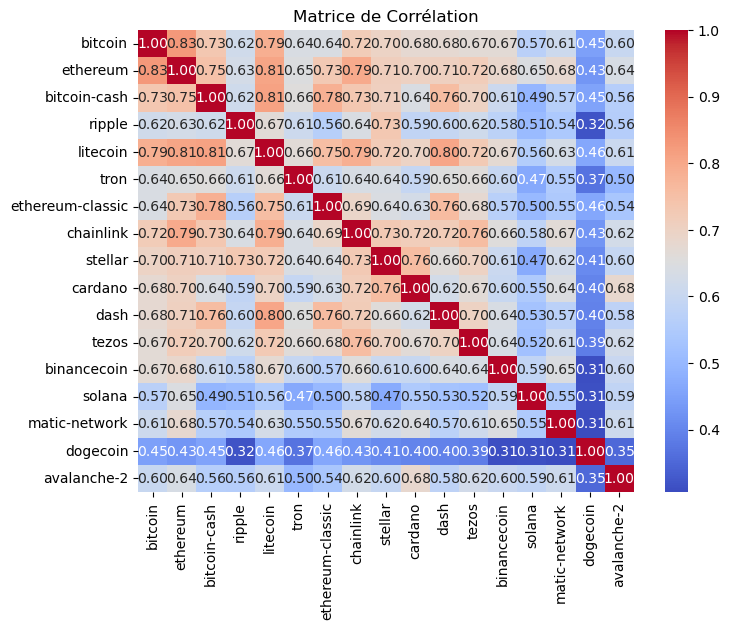

In [4]:
# Données
rdtdaily = np.diff(np.log(dailycryptodata), axis=0)
nomsColonnesString = 'bitcoin,ethereum,bitcoin-cash,ripple,litecoin,tron,ethereum-classic,chainlink,stellar,cardano,dash,tezos,binancecoin,solana,matic-network,dogecoin,avalanche-2'
cellulesNomsColonnes = nomsColonnesString.split(',')
nomsColonnes = [col.strip() for col in cellulesNomsColonnes]

# Calcul de la matrice de corrélation
matriceCorrelation = np.corrcoef(rdtdaily, rowvar=False)

# Ajustement de la taille de la figure
plt.figure(figsize=(8, 6))

# Création du heatmap avec seaborn
sns.heatmap(matriceCorrelation, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=nomsColonnes, yticklabels=nomsColonnes)

# Ajout d'un titre
plt.title('Matrice de Corrélation')

# Affichage de la figure
plt.show()

Nous constatons qu'aucune des cryptomonnaies détiennent des corrélations négatives entre elles, il existe seulement un dégré d'indépendance entre elles. Le niveau de plus faible corrélation est entre le Solana/ le dogecoin et le binancecoin/le dogecoin avec 0.31. Le niveau le plus élevée est entre les deux plus grosses cryptomonnaies (Bitcoin/Ethereum) avec 0.83, que nous allons considérons comme nos cryptomonnaies représentant le marché.

Etude des autocorrélations partielles des rendements

C:\Users\aikan\AppData\Local\Temp\ipykernel_13776\223711856.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(nbColonnes, 3, i + 1)
C:\Users\aikan\AppData\Local\Temp\ipykernel_13776\223711856.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(nbColonnes, 3, i + 1)
C:\Users\aikan\AppData\Local\Temp\ipykernel_13776\223711856.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(nbColonnes, 3, i + 1)
C:\Users\aikan\AppData\Local\Temp\ipykernel_13776\223711856.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two m

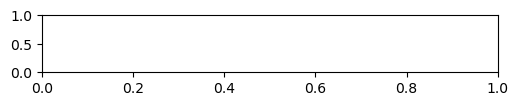

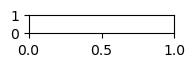

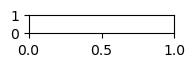

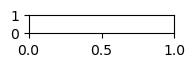

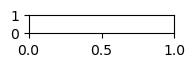

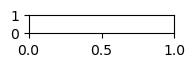

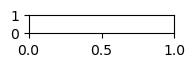

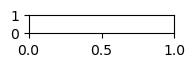

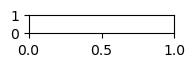

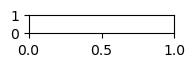

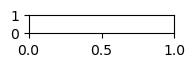

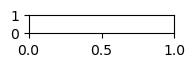

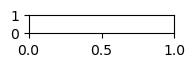

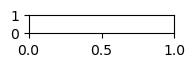

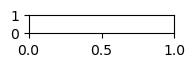

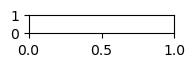

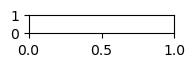

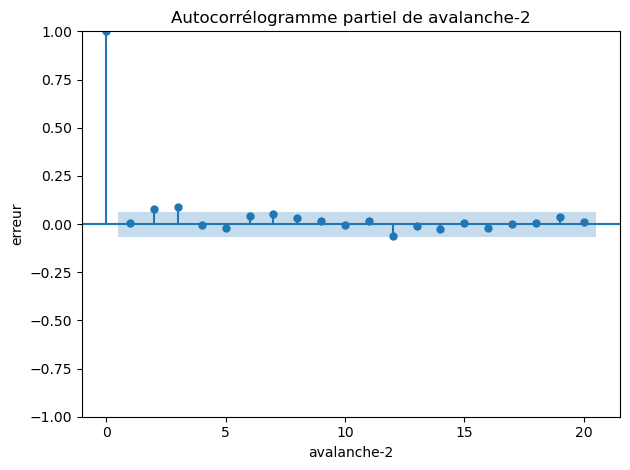

In [7]:

# Ajustement de la taille de la figure
plt.figure(figsize=(20, 15))

# Boucle pour créer les subplots
for i in range(nbColonnes):
    plt.subplot(nbColonnes, 3, i + 1)
    
    # Afficher l'histogramme de la colonne actuelle
    plot_pacf(rdtdaily[:, i], lags=20)
    
    # Ajouter des étiquettes et un titre
    plt.xlabel(nomsColonnes[i])
    plt.ylabel('erreur')
    plt.title(f'Autocorrélogramme partiel de {nomsColonnes[i]}')

# Ajuster la disposition
plt.tight_layout()

# Affichage de la figure
plt.show()


## Les choix diversification 
Dispersion des monnaies par ecart types et moyennes de leur capitalisation, de leur rendement et de leur volume

In [5]:
meanCap = np.mean(Mktcapvoldata, axis=0)
stdCap = np.std(Mktcapvoldata, axis=0)

meanrdt = np.mean(rdtdaily, axis=0)
stdrdt = np.std(rdtdaily, axis=0)

meanVolume = np.mean(volumebinancedata, axis=0)
stdVolume = np.std(volumebinancedata, axis=0)

Diversfication par la capitalisation

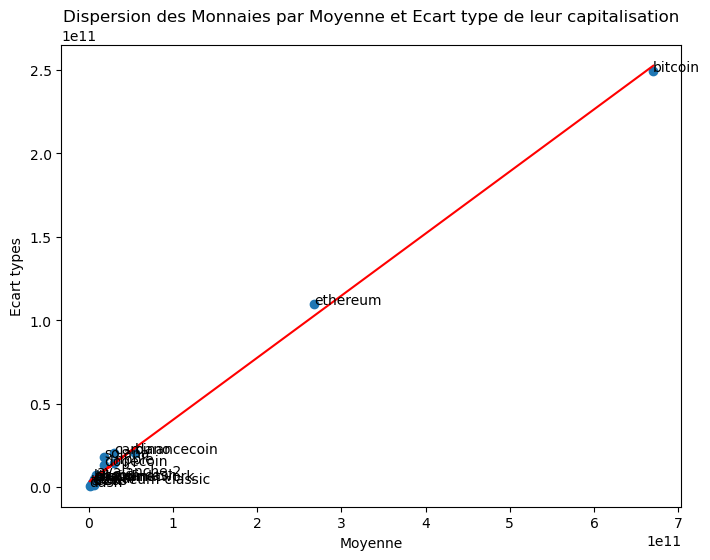

In [9]:
# Tracer un graphe de dispersion
plt.figure(figsize=(8, 6))
plt.scatter(meanCap, stdCap)

# Tracer la droite de régression linéaire
b, m = polyfit(meanCap, stdCap, 1)
plt.plot(meanCap, b + m * meanCap, color='red')

# Ajouter des étiquettes aux points
for i in range(len(nomsColonnes)):
    plt.text(meanCap[i], stdCap[i], nomsColonnes[i])

# Ajouter des étiquettes et un titre
plt.xlabel('Moyenne')
plt.ylabel('Ecart types')
plt.title('Dispersion des Monnaies par Moyenne et Ecart type de leur capitalisation')

plt.show()

A l'échelle logaritmique

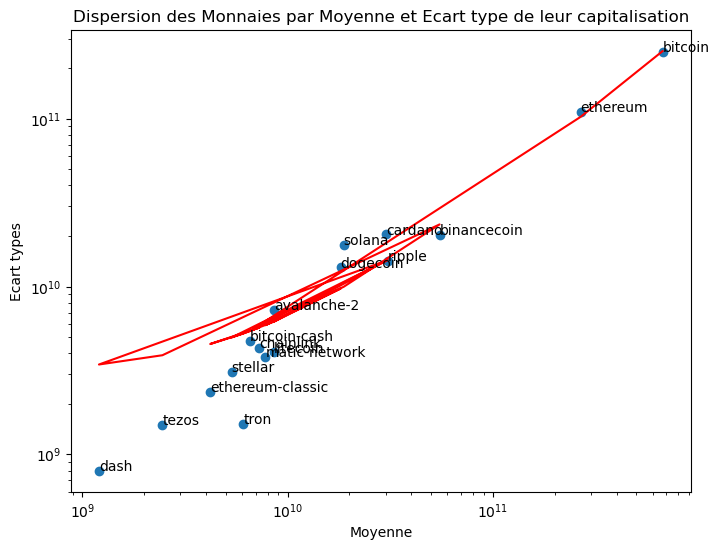

In [10]:

# Tracer un graphe de dispersion
plt.figure(figsize=(8, 6))
plt.scatter(meanCap, stdCap)

# Tracer la droite de régression linéaire
b, m = polyfit(meanCap, stdCap, 1)
plt.plot(meanCap, b + m * meanCap, color='red')

# Ajouter des étiquettes aux points
for i in range(len(nomsColonnes)):
    plt.text(meanCap[i], stdCap[i], nomsColonnes[i])

# Ajouter des étiquettes et un titre
plt.xlabel('Moyenne')
plt.ylabel('Ecart types')
plt.title('Dispersion des Monnaies par Moyenne et Ecart type de leur capitalisation')

# Mettre à l'échelle logarithmique
plt.xscale('log')
plt.yscale('log')

plt.show()


Nous retraçons la droite de régression en supprimant Bitcoin et Ethereum puisque leur capitalisation est largement plus élevée que les autres cryptomonnaies. Ainsi, nous allons les mettre dans une catégorie LargeCap Crypto.

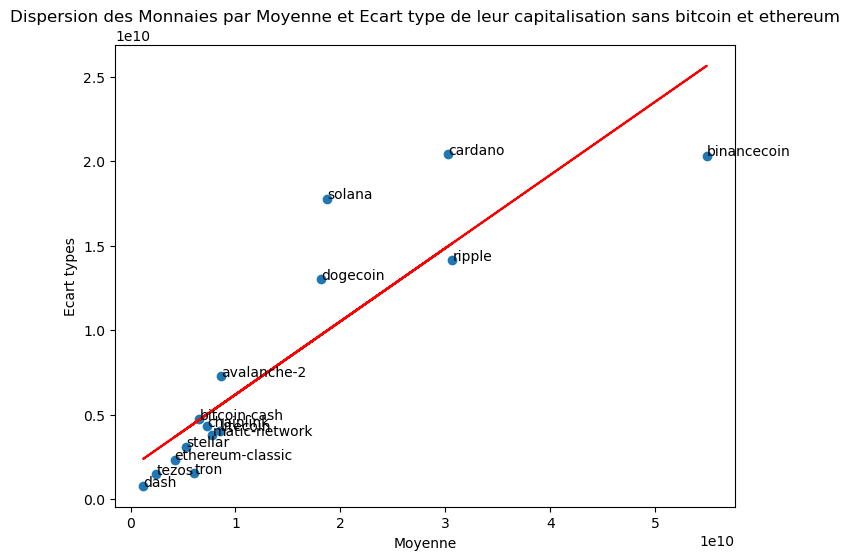

In [11]:

# Tracer un graphe de dispersion sans bitcoin et ethereum
plt.figure(figsize=(8, 6))
plt.scatter(meanCap[2:], stdCap[2:])

# Tracer la droite de régression linéaire
b, m = polyfit(meanCap[2:], stdCap[2:], 1)
plt.plot(meanCap[2:], b + m * meanCap[2:], color='red')

# Ajouter des étiquettes aux points
for i in range(2, len(nomsColonnes)):
    plt.text(meanCap[i], stdCap[i], nomsColonnes[i])

# Ajouter des étiquettes et un titre
plt.xlabel('Moyenne')
plt.ylabel('Ecart types')
plt.title('Dispersion des Monnaies par Moyenne et Ecart type de leur capitalisation sans bitcoin et ethereum')

plt.show()


Au vue de ce graphique nous pouvons mieux discerner les autres capitalisations avec en MidCap (Cardano, BinanceCoin, ripple, solana, Dogecoin, Avanlache-2) et en SmallCap (Bitcoin-cash, chainlink, litecoin, matic-network, stellar,ethereum-classic, tron, tezos, dash)

### Diversification par le volume

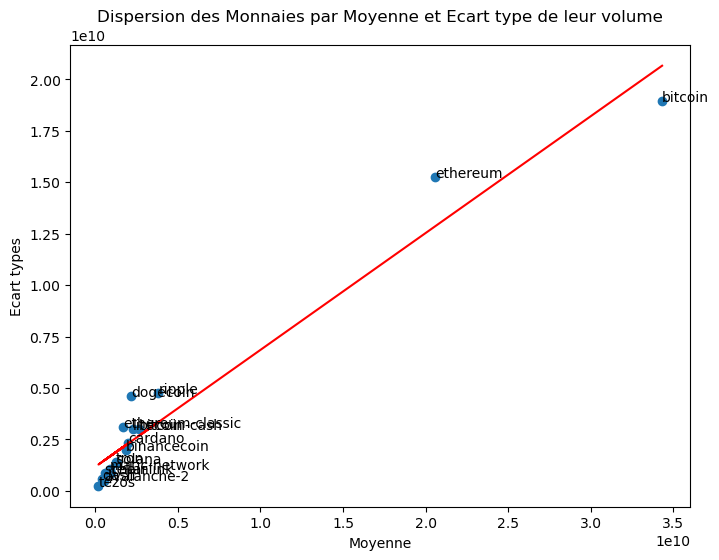

In [12]:

# Tracer un graphe de dispersion du volume
plt.figure(figsize=(8, 6))
plt.scatter(meanVolume, stdVolume)

# Tracer la droite de régression linéaire
b, m = polyfit(meanVolume, stdVolume, 1)
plt.plot(meanVolume, b + m * meanVolume, color='red')

# Ajouter des étiquettes aux points
for i in range(len(nomsColonnes)):
    plt.text(meanVolume[i], stdVolume[i], nomsColonnes[i])

# Ajouter des étiquettes et un titre
plt.xlabel('Moyenne')
plt.ylabel('Ecart types')
plt.title('Dispersion des Monnaies par Moyenne et Ecart type de leur volume')

plt.show()


Des résultats similaires à celui de la régression sur le volume, les plus gros volumes d'échanges sont les plus grosses capitalisations .

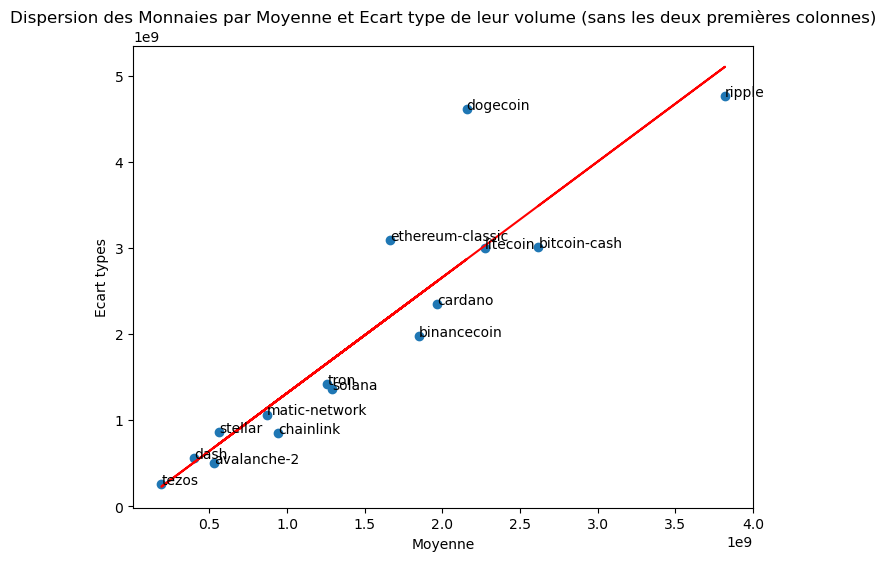

In [13]:

# Tracer un graphe de dispersion du volume sans les deux premières colonnes
plt.figure(figsize=(8, 6))
plt.scatter(meanVolume[2:], stdVolume[2:])

# Tracer la droite de régression linéaire
b, m = polyfit(meanVolume[2:], stdVolume[2:], 1)
plt.plot(meanVolume[2:], b + m * meanVolume[2:], color='red')

# Ajouter des étiquettes aux points
for i in range(2, len(nomsColonnes)):
    plt.text(meanVolume[i], stdVolume[i], nomsColonnes[i])

# Ajouter des étiquettes et un titre
plt.xlabel('Moyenne')
plt.ylabel('Ecart types')
plt.title('Dispersion des Monnaies par Moyenne et Ecart type de leur volume (sans les deux premières colonnes)')

plt.show()


Néanmoins nous avons quelques différences entre les volumes Mid et les Mid cap; les "small" Volumes et les "small" capitalisations. 
MidVolume=dogecoin,ripple, ethereum-classic,litecoin, bitcoin-cash, cardano, binancecoin

SmallVolume=Tron, solana, matic-network, stellar, chainlink, dash, avalanche-2,tezos

Le smallVolume est un facteur essentiel à prendre au sein de la construction de notre portefeuille puisqu'il indique une faible liquidité du produit donc la difficulté de rebalancer le portefeuille si nécessaire.


### Diversification par les rendements
Nous allons regarder la dispersion des cryptos en fonction de leur moyenne et de leur écart type, ces résultats pourront être vu comme un proxy du ratio de Sharpe (en supposant un taux sans risque à 0).

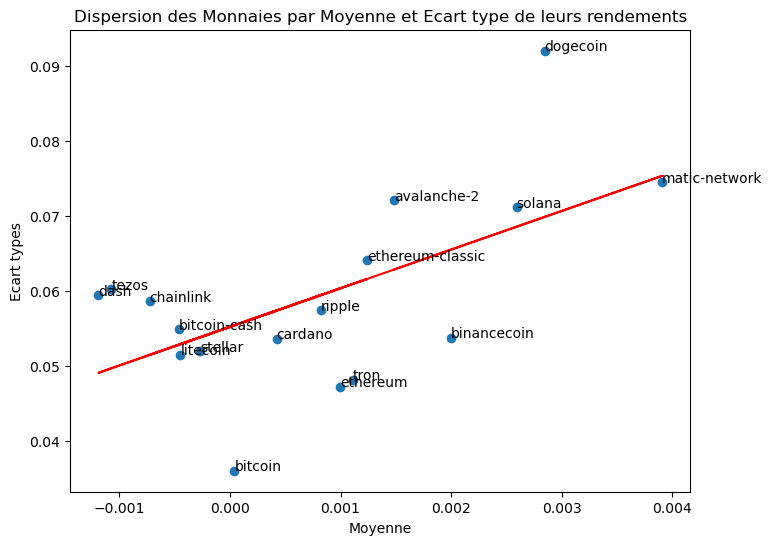

In [14]:
# Tracer un graphe de dispersion des rendements
plt.figure(figsize=(8, 6))
plt.scatter(meanrdt, stdrdt)

# Tracer la droite de régression linéaire
b, m = polyfit(meanrdt, stdrdt, 1)
plt.plot(meanrdt, b + m * meanrdt, color='red')

# Ajouter des étiquettes aux points
for i in range(len(nomsColonnes)):
    plt.text(meanrdt[i], stdrdt[i], nomsColonnes[i])

# Ajouter des étiquettes et un titre
plt.xlabel('Moyenne')
plt.ylabel('Ecart types')
plt.title('Dispersion des Monnaies par Moyenne et Ecart type de leurs rendements')

plt.show()


Nous constatons qu'une partie des rendements rapportent des rendements négatifs avec un minimum de volatilité.

# Construction des portefeuilles

Dans cette partie, nous allons construire les différents portefeuilles : MDP, MinVar, portefeuille à contribution égale au risque et le portefeuille équipondéré. Une fois la construction de ces différents portefeuilles avec les différents rendements jounaliers de chaque cryptomonnaies, nous allons modéliser leurs évolutions à l'aide de différents modèles à un ou plusieurs facteurs.

## Most Doversified Portfolio


Dans un premier temps, nous allons considérer le MDP, le portefeuille qui minimise le diversification ratio, 
\begin{align*}
& \quad DR(w) = \left[CR(w)(1 - \rho(w)) + \rho(w)\right]^{-\frac{1}{2}} \\
\end{align*}
avec 
\begin{align*}
&\text{Volatility Weighted Average Correlation} = \frac{\sum_{i \neq j} w_i \cdot w_j \cdot \rho(i, j) \cdot \sigma_i \cdot \sigma_j}{\sum_{i \neq j} w_i \cdot \sigma_i \cdot w_j \cdot \sigma_j}
\end{align*}

\begin{align*}
\text{Min :} & \quad DR(w) \\
\text{Sous contrainte :} & \quad \sum_{i=1}^{N} w_i = 1 \\
& \quad \Sigma w^{MDP} \geq \frac{\sigma(w^{MDP}) \sigma_i}{DR(w^{MDP})} \\
& \text{Où :} & \quad w = [w_1, w_2, \ldots, w_N] \quad \text{(vecteur des pondérations des actifs)} \\
& \quad \Sigma \quad \text{(matrice de covariance des rendements)} \\
& \quad N \quad \text{(nombre d'actifs)}
\end{align*}


In [6]:
real_cov = np.array([[.8, .3],
                     [.3, .4]])
rng = np.random.RandomState(0)
X = rng.multivariate_normal(mean=[0, 0],
                                   cov=real_cov,
                                   size=500)
cov = ShrunkCovariance().fit(real_cov)
cov.covariance_

array([[ 0.0595 , -0.01125],
       [-0.01125,  0.0055 ]])

In [108]:
#from riskfolio.RiskFunctions import Covariances #A installer pour shrinker la matrice de covariance 

def VWAC(weights, correlations, volatilities):
    N = len(weights)
    
    numerator = np.sum(weights[i] * weights[j] * correlations[i, j] * volatilities[i] * volatilities[j] 
                      for i in range(N) for j in range(N) if i != j)
    
    denominator = np.sum(weights[i] * weights[j] * volatilities[i] * volatilities[j] 
                        for i in range(N) for j in range(N) if i != j)
    
    return numerator / denominator

def CR(w, covariance_matrix):
    N = len(w)
    CRatio = 0
    CRatio2=0
    volatility_vector = np.diag(covariance_matrix)
    total_volatility = np.sqrt(np.dot(w.T, np.dot(covariance_matrix, w)))

    for i in range(N):
        CRatio += (w[i] * volatility_vector[i]) ** 2
        CRatio2+=w[i] * volatility_vector[i]
    return  CRatio / (CRatio2 ** 2)

Covariance = np.cov(rdtdaily, rowvar=False) #rebalancement annuel
Corrmatrix=np.corrcoef(rdtdaily, rowvar=False)

C_shrunk= Covariance

def DR(w, covariance_matrix = C_shrunk, corrmatrix = Corrmatrix):
    dr=((CR(w, covariance_matrix) * (1 - VWAC(w,corrmatrix,covariance_matrix)) + VWAC(w,corrmatrix,covariance_matrix))**-0.5)
    #dr=np.dot(w.T, C_shrunk)/np.sqrt(np.dot(w.T, np.dot(C_shrunk, w)))
    return np.dot(w.T,dr)

def DRobj(w) :
    return -np.log(DR(w))

# Contraintes d'égalité
Aeq = np.ones((1, rdtdaily.shape[1]))
beq = 1

# Bornes des variables de décision
lb =np.zeros(rdtdaily.shape[1])
ub = np.ones(rdtdaily.shape[1])

# Initialisation des variables
x0 = np.ones(rdtdaily.shape[1]) / rdtdaily.shape[1]

def ineq_constraint(w):
    return np.dot(Covariance, w) - (np.sqrt(np.var(w)) / DR(w)) * np.diag(Covariance)

# Résolution du problème d'optimisation
resultMDP = minimize(DRobj, x0, constraints=[{'type': 'eq', 'fun': lambda w: Aeq.dot(w) - beq},{'type': 'ineq', 'fun': ineq_constraint}],
                  bounds=[(l, u) for l, u in zip(lb, ub)], options={'disp': True})

xMDP = resultMDP.x
DRMDP = DR(xMDP)

# Affichage des résultats
print("Résultats de l'optimisation :")
print("Variables optimales :", xMDP)
portfolioVarMDP = xMDP @ C_shrunk @ xMDP
print("Variance du portefeuille MDP :", np.dot(xMDP.T, np.dot(C_shrunk, xMDP)))
print("Diversification ratio :", DRMDP)


# Récupération du rendement du portefeuille avec la pondération du portefeuille
RptfMDP = np.dot(xMDP, rdtdaily.T)
MktcapvolMDP = np.dot(xMDP, Mktcapvoldata.T)
volumeMDP = np.dot(xMDP, volumebinancedata.T)



C:\Users\aikan\AppData\Local\Temp\ipykernel_31972\3353046491.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numerator = np.sum(weights[i] * weights[j] * correlations[i, j] * volatilities[i] * volatilities[j]
C:\Users\aikan\AppData\Local\Temp\ipykernel_31972\3353046491.py:9: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  denominator = np.sum(weights[i] * weights[j] * volatilities[i] * volatilities[j]


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.2833701989830898
            Iterations: 10
            Function evaluations: 181
            Gradient evaluations: 10
Résultats de l'optimisation :
Variables optimales : [1.39367555e-18 2.08116930e-17 1.89593557e-17 1.57197037e-01
 3.13413720e-17 2.09657109e-01 6.70330201e-02 2.30335289e-17
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.08275179e-03 1.72909273e-01 1.11740420e-01 1.80852049e-01
 9.85283392e-02]
Variance du portefeuille MDP : 0.0025089027901167398
Diversification ratio : 1.327596545747819


In [105]:
print(f"Contrainte d'inégalité : {np.all(np.dot(Covariance, xMDP) - (np.sqrt(np.var(xMDP)) / DR(xMDP)) * np.diag(Covariance)>0)}")

Contrainte d'inégalité : True


C:\Users\aikan\AppData\Local\Temp\ipykernel_31972\3353046491.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numerator = np.sum(weights[i] * weights[j] * correlations[i, j] * volatilities[i] * volatilities[j]
C:\Users\aikan\AppData\Local\Temp\ipykernel_31972\3353046491.py:9: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  denominator = np.sum(weights[i] * weights[j] * volatilities[i] * volatilities[j]


In [68]:
def test_convergence(xMDP):
    error_count = 0
    total_count = 0
    failing_cases = []
    successful_cases = [] 
    successful_MDP = []
    failing_DR = []

    dr_opt = round(DR(xMDP), 5)
    interval = [dr_opt + i / 10000 for i in range(-1, 2, 1)]

    custom_value_strategy = st.one_of(
        st.just(0),
        st.floats(min_value=1e-18, max_value=1.0))

    @settings(deadline=3000, max_examples=1000)
    @given(st.lists(custom_value_strategy, min_size=len(xMDP), max_size=len(xMDP)))
    def check_convergence(w):
        nonlocal error_count, total_count, failing_cases, successful_cases, successful_MDP, failing_DR, interval
        total_count += 1

        w = np.array(w)
        sum_w = np.sum(w)
        if sum_w == 0:
            total_count -= 1
        else:
            w /= sum_w  # Normaliser w pour que la somme des coefficients soit 1
            result = minimize(DRobj, w, constraints=({'type': 'eq', 'fun': lambda y: Aeq.dot(y) - beq}),
                              bounds=[(l, u) for l, u in zip(lb, ub)], options={'disp': False})

            x = result.x
            dr = round(DR(x), 5)
            
            if not np.isnan(dr):
                try:
                    assert dr in interval
                    successful_cases.append(w)
                    successful_MDP.append(x)  # Ajouter w à la liste des cas réussis
                except AssertionError:
                    error_count += 1
                    failing_cases.append(w)
                    failing_DR.append(dr)
                    print(f"DR(w) : {dr}")

    check_convergence()

    print(f"Nombre total de cas testés : {total_count}")
    print(f"Nombre de cas ayant échoué : {error_count}")
    print(f"Taux de réussite : {round((1 - error_count / total_count) * 100, 2)}%")

    return successful_cases, successful_MDP
    
# Utilisation de la fonction avec un vecteur xMDP donné
print(f"DR optimal : {round(DRMDP,5)}")
successful_cases, successful_MDP =test_convergence(xMDP)

DR optimal : 1.3276


C:\Users\aikan\AppData\Local\Temp\ipykernel_13776\288374162.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numerator = np.sum(weights[i] * weights[j] * correlations[i, j] * volatilities[i] * volatilities[j]
C:\Users\aikan\AppData\Local\Temp\ipykernel_13776\288374162.py:9: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  denominator = np.sum(weights[i] * weights[j] * volatilities[i] * volatilities[j]
C:\Users\aikan\AppData\Local\Temp\ipykernel_13776\288374162.py:12: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


DR(w) : 1.32759
DR(w) : 1.32759
DR(w) : 1.32759
DR(w) : 1.32759
DR(w) : 1.32759
DR(w) : 1.32759
DR(w) : 1.32759
DR(w) : 1.32759
Nombre total de cas testés : 999
Nombre de cas ayant échoué : 8
Taux de réussite : 99.2%


In [69]:
pd.DataFrame(successful_cases)

0             1             2         3             4         5   \
0    0.097123  1.070871e-01  1.157802e-08  0.194247  0.000000e+00  0.194247   
1    0.000000  7.499313e-19  4.577218e-05  0.000000  7.499313e-19  0.000000   
2    0.210323  2.103227e-06  0.000000e+00  0.000000  0.000000e+00  0.000000   
3    0.000000  1.876471e-01  1.145307e-05  0.145192  0.000000e+00  0.000000   
4    0.000000  0.000000e+00  2.522093e-01  0.000000  1.062168e-01  0.318650   
..        ...           ...           ...       ...           ...       ...   
965  0.000000  0.000000e+00  0.000000e+00  0.000000  0.000000e+00  0.000000   
966  0.000000  0.000000e+00  0.000000e+00  0.000000  0.000000e+00  0.000000   
967  0.000000  0.000000e+00  0.000000e+00  0.000000  0.000000e+00  0.000000   
968  0.000000  0.000000e+00  0.000000e+00  0.000000  0.000000e+00  0.000000   
969  0.000000  0.000000e+00  0.000000e+00  0.000000  0.000000e+00  0.000000   

               6             7             8             9         10  \
0    0.000000e+00  1.020163e-01  1.185589e-05  2.315603e-08  0.000000   
1    7.499313e-19  2.499771e-01  0.000000e+00  0.000000e+00  0.000000   
2    1.550762e-01  2.103227e-01  2.103227e-06  0.000000e+00  0.210323   
3    1.042077e-01  1.876452e-01  1.876471e-06  0.000000e+00  0.187647   
4    1.593252e-01  3.186505e-19  1.899305e-08  3.186505e-19  0.000000   
..            ...           ...           ...           ...       ...   
965  3.463472e-19  3.463437e-01  0.000000e+00  0.000000e+00  0.000000   
966  3.463472e-19  3.463437e-01  0.000000e+00  0.000000e+00  0.000000   
967  4.476543e-19  4.476498e-01  0.000000e+00  0.000000e+00  0.000000   
968  4.476543e-19  4.476498e-01  0.000000e+00  0.000000e+00  0.000000   
969  4.476543e-19  4.476498e-01  0.000000e+00  0.000000e+00  0.000000   

           11            12            13        14        15        16  
0    0.194245  0.000000e+00  1.389720e-02  0.000000  0.000002  0.097123  
1    0.749931  0.000000e+00  1.665182e-16  0.000046  0.000000  0.000000  
2    0.000000  2.103227e-19  3.628800e-03  0.210323  0.000000  0.000000  
3    0.187647  0.000000e+00  2.236928e-08  0.000000  0.000000  0.000000  
4    0.159325  0.000000e+00  0.000000e+00  0.004273  0.000000  0.000000  
..        ...           ...           ...       ...       ...       ...  
965  0.000000  3.463472e-01  2.668079e-01  0.040501  0.000000  0.000000  
966  0.000000  3.463472e-01  2.668079e-01  0.040501  0.000000  0.000000  
967  0.000000  4.476543e-01  5.234791e-02  0.052348  0.000000  0.000000  
968  0.000000  4.476543e-01  5.234791e-02  0.052348  0.000000  0.000000  
969  0.000000  4.476543e-01  5.234791e-02  0.052348  0.000000  0.000000  

[970 rows x 17 columns]

In [70]:
pd.DataFrame(successful_MDP)

0             1             2         3             4   \
0    3.890787e-17  2.149415e-17  0.000000e+00  0.156836  3.689739e-17   
1    0.000000e+00  2.730817e-17  3.442075e-17  0.158062  5.297957e-18   
2    0.000000e+00  0.000000e+00  0.000000e+00  0.157134  0.000000e+00   
3    0.000000e+00  0.000000e+00  0.000000e+00  0.156855  5.664822e-17   
4    1.282576e-17  0.000000e+00  2.826139e-17  0.157555  0.000000e+00   
..            ...           ...           ...       ...           ...   
965  0.000000e+00  1.213535e-16  1.068984e-16  0.156431  0.000000e+00   
966  0.000000e+00  1.213535e-16  1.068984e-16  0.156431  0.000000e+00   
967  7.099857e-18  3.358717e-17  9.947224e-18  0.157127  0.000000e+00   
968  7.099857e-18  3.358717e-17  9.947224e-18  0.157127  0.000000e+00   
969  7.099857e-18  3.358717e-17  9.947224e-18  0.157127  0.000000e+00   

           5         6             7             8             9   \
0    0.209018  0.067604  0.000000e+00  9.939284e-19  0.000000e+00   
1    0.208758  0.066683  0.000000e+00  4.940559e-18  0.000000e+00   
2    0.209606  0.066416  4.811297e-17  0.000000e+00  1.635378e-17   
3    0.209451  0.066851  0.000000e+00  7.931712e-18  4.062287e-18   
4    0.209310  0.066386  0.000000e+00  0.000000e+00  7.376485e-18   
..        ...       ...           ...           ...           ...   
965  0.209861  0.067532  0.000000e+00  0.000000e+00  0.000000e+00   
966  0.209861  0.067532  0.000000e+00  0.000000e+00  0.000000e+00   
967  0.210285  0.066561  5.136347e-18  1.534210e-17  7.584482e-18   
968  0.210285  0.066561  5.136347e-18  1.534210e-17  7.584482e-18   
969  0.210285  0.066561  5.136347e-18  1.534210e-17  7.584482e-18   

               10            11        12        13        14        15  \
0    0.000000e+00  0.000000e+00  0.003295  0.172644  0.111144  0.180751   
1    0.000000e+00  1.072934e-17  0.003840  0.173055  0.111080  0.180548   
2    3.566932e-18  0.000000e+00  0.003834  0.172680  0.111086  0.180698   
3    0.000000e+00  7.999076e-18  0.002896  0.172957  0.111452  0.180853   
4    2.661922e-17  0.000000e+00  0.002879  0.172860  0.111495  0.180876   
..            ...           ...       ...       ...       ...       ...   
965  0.000000e+00  6.291593e-18  0.001216  0.173401  0.111815  0.180950   
966  0.000000e+00  6.291593e-18  0.001216  0.173401  0.111815  0.180950   
967  0.000000e+00  9.707574e-19  0.001435  0.173291  0.111907  0.180975   
968  0.000000e+00  9.707574e-19  0.001435  0.173291  0.111907  0.180975   
969  0.000000e+00  9.707574e-19  0.001435  0.173291  0.111907  0.180975   

           16  
0    0.098709  
1    0.097974  
2    0.098547  
3    0.098686  
4    0.098640  
..        ...  
965  0.098793  
966  0.098793  
967  0.098418  
968  0.098418  
969  0.098418  

[970 rows x 17 columns]

In [99]:
def correlation(w, w_s, covariance_matrix):
    return np.dot(w.T,np.dot(covariance_matrix,w_s))/np.sqrt(np.var(w_s)*np.var(w))

def test_correlation(xopt):
    error_count = 0
    total_count = 0
    failing_cases = []
    failing_DR = []
    failing_rho = []
    failing_ratio = []

    dr_opt = DR(xopt)
    custom_value_strategy = st.one_of(
        st.just(0),
        st.floats(min_value=1e-18, max_value=1.0))

    @settings(max_examples=1000)
    @given(st.lists(custom_value_strategy, min_size=len(xopt), max_size=len(xopt)))
    def check_correlation(w):
        nonlocal error_count, total_count, failing_cases, failing_DR, failing_rho, failing_ratio
        total_count += 1

        w = np.array(w)
        sum_w = np.sum(w)
        # Vérification supplémentaire pour éviter la division par zéro
        if sum_w == 0 :
            total_count-=1
        else :
            w /= sum_w  # Normaliser w pour que la somme des coefficients soit 1
            cov_mat = np.cov(rdtdaily, rowvar=False) 
            rho = round(correlation(w, xopt, cov_mat), 4)
            ratio = round(DR(w) / dr_opt, 4)
            if np.isnan(ratio) :
                total_count-=1
            else :
                try:
                    assert rho >= ratio
                except AssertionError:
                    error_count += 1
                    failing_cases.append(w)
                    failing_rho.append(rho)
                    failing_DR.append(DR(w))
                    failing_ratio.append(ratio)
                    print(f"rho : {rho}, ratio : {ratio}, DR is max: {ratio<=1}")

    check_correlation()
        
    return [total_count, error_count]

# Utilisation de la fonction avec un vecteur xMDP donné
[total_count, error_count] = test_correlation(xMDP)
print(f"Nombre total de cas testés : {total_count}")
print(f"Nombre de cas ayant échoué : {error_count}")
print(f"Taux de réussite : {round((1-error_count/total_count)*100,2)}%")

C:\Users\aikan\AppData\Local\Temp\ipykernel_31972\1620312861.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numerator = np.sum(weights[i] * weights[j] * correlations[i, j] * volatilities[i] * volatilities[j]
C:\Users\aikan\AppData\Local\Temp\ipykernel_31972\1620312861.py:9: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  denominator = np.sum(weights[i] * weights[j] * volatilities[i] * volatilities[j]
C:\Users\aikan\AppData\Local\Temp\ipykernel_31972\1620312861.py:12: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


rho : 0.3856, ratio : 0.9409, DR is max: True
rho : 0.3317, ratio : 0.8811, DR is max: True
rho : 0.1851, ratio : 0.8608, DR is max: True
rho : 0.1451, ratio : 0.8257, DR is max: True
rho : 0.2735, ratio : 0.8721, DR is max: True
rho : 0.2965, ratio : 0.9235, DR is max: True
rho : 0.3197, ratio : 0.9184, DR is max: True
rho : 0.3432, ratio : 0.9048, DR is max: True
rho : 0.3211, ratio : 0.9048, DR is max: True
rho : 0.3166, ratio : 0.8848, DR is max: True
rho : 0.2969, ratio : 0.8941, DR is max: True
rho : 0.3154, ratio : 0.9003, DR is max: True
rho : 0.3044, ratio : 0.8981, DR is max: True
rho : 0.2428, ratio : 0.8996, DR is max: True
rho : 0.2836, ratio : 0.8928, DR is max: True
rho : 0.2903, ratio : 0.8799, DR is max: True
rho : 0.2558, ratio : 0.8619, DR is max: True
rho : 0.3853, ratio : 0.8695, DR is max: True
rho : 0.32, ratio : 0.907, DR is max: True
rho : 0.3309, ratio : 0.9065, DR is max: True
rho : 0.3309, ratio : 0.9065, DR is max: True
rho : 0.3627, ratio : 0.9472, DR is m

In [ ]:
def test_MDP(Xopt, xinit = xMDP):
    rate_min = 1
    MDPopt = []
    for xopt in Xopt :
        res = test_correlation(xopt)
        rate = res[1]/res[0]
        if rate < rate_min :
            MDPopt = xopt 
            rate_min = rate
    if rate_min == 1 :
        MDPopt = xinit
    return [MDPopt, rate_min]

[MDPopt,r] = test_MDP(successful_MDP)
print(f"MDP optimal : {MDPopt}")
print(f"Taux de réussite : {round((1-r)*100,2)}")


In [55]:
def test_DR(xMDP):
    error_count = 0
    total_count = 0
    failing_cases = []
    failing_DR = []
    failing_rho = []
    failing_ratio = []

    dr_opt = DR(xMDP)
    custom_value_strategy = st.one_of(
        st.just(0),
        st.floats(min_value=1e-18, max_value=1.0))

    @settings(max_examples=1000)
    @given(st.lists(custom_value_strategy, min_size=len(xMDP), max_size=len(xMDP)))
    def check_DR(w):
        nonlocal error_count, total_count, failing_cases, failing_DR, failing_rho, failing_ratio
        total_count += 1

        w = np.array(w)
        sum_w = np.sum(w)
        # Vérification supplémentaire pour éviter la division par zéro
        if sum_w == 0 :
            total_count-=1
        else :
            w /= sum_w  # Normaliser w pour que la somme des coefficients soit 1
            cov_mat = np.cov(rdtdaily, rowvar=False)
            rho = round(correlation(w, xMDP, cov_mat), 4)
            ratio = round(DR(w) / dr_opt, 4)
            if np.isnan(ratio) :
                total_count-=1
            else :
                try:
                    assert ratio<=1
                except AssertionError:
                    error_count += 1
                    failing_cases.append(w)
                    failing_rho.append(rho)
                    failing_DR.append(DR(w))
                    failing_ratio.append(ratio)
                    print(f"rho : {rho} ratio : {ratio}, DR(w) : {DR(w)}")

    check_DR()
    
    print(f"Nombre total de cas testés : {total_count}")
    print(f"Nombre de cas ayant échoué : {error_count}")
    print(f"Taux de réussite : {round((1-error_count/total_count)*100,2)}%")
    
# Utilisation de la fonction avec un vecteur xMDP donné
test_DR(xMDP)

C:\Users\aikan\AppData\Local\Temp\ipykernel_13776\288374162.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numerator = np.sum(weights[i] * weights[j] * correlations[i, j] * volatilities[i] * volatilities[j]
C:\Users\aikan\AppData\Local\Temp\ipykernel_13776\288374162.py:9: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  denominator = np.sum(weights[i] * weights[j] * volatilities[i] * volatilities[j]
C:\Users\aikan\AppData\Local\Temp\ipykernel_13776\288374162.py:12: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


Nombre total de cas testés : 981
Nombre de cas ayant échoué : 0
Taux de réussite : 100.0%


In [30]:
np.sum(np.array([0.00000000e+000, 0.00000000e+000, 7.70387393e-002, 1.52575409e-001,
 1.71416885e-309, 0.00000000e+000, 1.54077479e-001, 2.15908534e-046,
 1.54077479e-001, 1.81117206e-039, 3.42120729e-017, 3.42833770e-312,
 1.54077479e-001, 0.00000000e+000, 3.42833770e-312, 1.54075938e-001,
 1.54077479e-001]))

1.0000000023

In [16]:
np.dot(x0.T,DR(x0))

C:\Users\aikan\AppData\Local\Temp\ipykernel_24888\1776390957.py:21: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numerator = np.sum(weights[i] * weights[j] * correlations[i, j] * volatilities[i] * volatilities[j]
C:\Users\aikan\AppData\Local\Temp\ipykernel_24888\1776390957.py:24: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  denominator = np.sum(weights[i] * weights[j] * volatilities[i] * volatilities[j]


array([0.07364575, 0.07364575, 0.07364575, 0.07364575, 0.07364575,
       0.07364575, 0.07364575, 0.07364575, 0.07364575, 0.07364575,
       0.07364575, 0.07364575, 0.07364575, 0.07364575, 0.07364575,
       0.07364575, 0.07364575])

In [17]:
pd.DataFrame(Covariance)

0         1         2         3         4         5         6   \
0   0.001296  0.001406  0.001448  0.001280  0.001458  0.001111  0.001477   
1   0.001406  0.002227  0.001938  0.001702  0.001962  0.001474  0.002205   
2   0.001448  0.001938  0.003017  0.001947  0.002298  0.001740  0.002761   
3   0.001280  0.001702  0.001947  0.003302  0.001970  0.001693  0.002080   
4   0.001458  0.001962  0.002298  0.001970  0.002652  0.001649  0.002488   
5   0.001111  0.001474  0.001740  0.001693  0.001649  0.002321  0.001870   
6   0.001477  0.002205  0.002761  0.002080  0.002488  0.001870  0.004113   
7   0.001522  0.002199  0.002365  0.002161  0.002374  0.001801  0.002593   
8   0.001306  0.001746  0.002022  0.002181  0.001932  0.001596  0.002148   
9   0.001306  0.001781  0.001884  0.001807  0.001927  0.001535  0.002155   
10  0.001448  0.001983  0.002475  0.002034  0.002459  0.001866  0.002903   
11  0.001446  0.002034  0.002319  0.002136  0.002245  0.001916  0.002615   
12  0.001295  0.001737  0.001796  0.001782  0.001860  0.001549  0.001955   
13  0.001461  0.002168  0.001929  0.002069  0.002039  0.001603  0.002292   
14  0.001640  0.002387  0.002318  0.002322  0.002411  0.001977  0.002606   
15  0.001489  0.001866  0.002290  0.001684  0.002190  0.001645  0.002730   
16  0.001560  0.002166  0.002232  0.002324  0.002248  0.001735  0.002478   

          7         8         9         10        11        12        13  \
0   0.001522  0.001306  0.001306  0.001448  0.001446  0.001295  0.001461   
1   0.002199  0.001746  0.001781  0.001983  0.002034  0.001737  0.002168   
2   0.002365  0.002022  0.001884  0.002475  0.002319  0.001796  0.001929   
3   0.002161  0.002181  0.001807  0.002034  0.002136  0.001782  0.002069   
4   0.002374  0.001932  0.001927  0.002459  0.002245  0.001860  0.002039   
5   0.001801  0.001596  0.001535  0.001866  0.001916  0.001549  0.001603   
6   0.002593  0.002148  0.002155  0.002903  0.002615  0.001955  0.002292   
7   0.003442  0.002218  0.002253  0.002511  0.002671  0.002074  0.002431   
8   0.002218  0.002703  0.002110  0.002037  0.002191  0.001693  0.001737   
9   0.002253  0.002110  0.002878  0.001990  0.002149  0.001731  0.002097   
10  0.002511  0.002037  0.001990  0.003534  0.002510  0.002040  0.002232   
11  0.002671  0.002191  0.002149  0.002510  0.003625  0.002060  0.002233   
12  0.002074  0.001693  0.001731  0.002040  0.002060  0.002889  0.002238   
13  0.002431  0.001737  0.002097  0.002232  0.002233  0.002238  0.005061   
14  0.002915  0.002408  0.002579  0.002544  0.002755  0.002589  0.002915   
15  0.002301  0.001954  0.001963  0.002163  0.002144  0.001532  0.002057   
16  0.002641  0.002234  0.002638  0.002477  0.002697  0.002340  0.003006   

          14        15        16  
0   0.001640  0.001489  0.001560  
1   0.002387  0.001866  0.002166  
2   0.002318  0.002290  0.002232  
3   0.002322  0.001684  0.002324  
4   0.002411  0.002190  0.002248  
5   0.001977  0.001645  0.001735  
6   0.002606  0.002730  0.002478  
7   0.002915  0.002301  0.002641  
8   0.002408  0.001954  0.002234  
9   0.002579  0.001963  0.002638  
10  0.002544  0.002163  0.002477  
11  0.002755  0.002144  0.002697  
12  0.002589  0.001532  0.002340  
13  0.002915  0.002057  0.003006  
14  0.005555  0.002100  0.003286  
15  0.002100  0.008476  0.002338  
16  0.003286  0.002338  0.005206

In [52]:
print(f"Déterminant de la matrice de covariance : {round(np.linalg.det(Covariance),54)}")
pd.DataFrame(np.linalg.inv(Covariance))

Déterminant de la matrice de covariance : 1.58713e-49


0            1            2           3            4   \
0   3139.284021 -1109.259809  -294.888511  -36.511418  -448.432664   
1  -1109.259809  2424.292986   -19.944682   70.076382  -327.017798   
2   -294.888511   -19.944682  1393.177573    7.022094  -378.933896   
3    -36.511418    70.076382     7.022094  782.883223  -167.651935   
4   -448.432664  -327.017798  -378.933896 -167.651935  2053.833017   
5   -128.160569   -36.143023  -114.222505 -145.126579    26.495346   
6    254.177622  -302.035766  -350.809811   -8.170545   -69.949422   
7     78.184446  -348.968495   -94.584919  -41.073779  -201.269113   
8   -139.577118   -92.345722  -175.897079 -420.338630    56.283099   
9   -123.749983    12.790375    85.879341  116.339069  -129.081949   
10    -9.542025   137.786057  -117.067483   29.578026  -439.278329   
11    21.280791   -42.221773   -48.001213  -14.395979   -16.747455   
12  -208.511200   -41.915882    14.444308  -33.008467   -75.815125   
13   -21.101267  -209.979124    43.418730  -75.733821    43.920660   
14    33.029898  -128.853595    32.603626    7.795897   -12.594165   
15   -84.066125    27.860973   -16.058670   26.107783   -44.734769   
16   -21.983015   -26.574810   -19.519029  -68.372969    43.011174   

             5           6            7            8            9   \
0   -128.160569  254.177622    78.184446  -139.577118  -123.749983   
1    -36.143023 -302.035766  -348.968495   -92.345722    12.790375   
2   -114.222505 -350.809811   -94.584919  -175.897079    85.879341   
3   -145.126579   -8.170545   -41.073779  -420.338630   116.339069   
4     26.495346  -69.949422  -201.269113    56.283099  -129.081949   
5   1023.667495   -0.679923    16.214271   -26.495163   -68.760267   
6     -0.679923  862.880715    28.416994    14.849755   -83.658216   
7     16.214271   28.416994  1182.579848   -96.337720  -134.158342   
8    -26.495163   14.849755   -96.337720  1462.224965  -475.719651   
9    -68.760267  -83.658216  -134.158342  -475.719651  1157.810907   
10  -127.138358 -271.181746   -82.816591   -33.668225    58.093007   
11  -152.664026  -76.242616  -225.866775  -113.259261   -15.729889   
12   -98.873462   28.467046   -26.471424    -5.315242    28.668492   
13     7.404884  -10.190165   -39.841665   131.426584   -55.779122   
14   -31.766062    7.107892   -78.366753   -58.919432   -75.630425   
15   -19.419528  -56.740579   -21.438189   -27.404136    -3.398352   
16    61.448426   27.452372     8.433813    33.739223  -203.743901   

             10          11          12          13          14          15  \
0     -9.542025   21.280791 -208.511200  -21.101267   33.029898  -84.066125   
1    137.786057  -42.221773  -41.915882 -209.979124 -128.853595   27.860973   
2   -117.067483  -48.001213   14.444308   43.418730   32.603626  -16.058670   
3     29.578026  -14.395979  -33.008467  -75.733821    7.795897   26.107783   
4   -439.278329  -16.747455  -75.815125   43.920660  -12.594165  -44.734769   
5   -127.138358 -152.664026  -98.873462    7.404884  -31.766062  -19.419528   
6   -271.181746  -76.242616   28.467046  -10.190165    7.107892  -56.740579   
7    -82.816591 -225.866775  -26.471424  -39.841665  -78.366753  -21.438189   
8    -33.668225 -113.259261   -5.315242  131.426584  -58.919432  -27.404136   
9     58.093007  -15.729889   28.668492  -55.779122  -75.630425   -3.398352   
10  1058.923619  -80.510550  -91.288684  -34.638886    8.170952   25.424902   
11   -80.510550  874.549389  -59.210356   13.268445  -19.476958    5.216077   
12   -91.288684  -59.210356  888.909551  -90.526702 -121.407199   28.098695   
13   -34.638886   13.268445  -90.526702  405.908800  -29.328394  -11.195622   
14     8.170952  -19.476958 -121.407199  -29.328394  431.352362   12.718852   
15    25.424902    5.216077   28.098695  -11.195622   12.718852  163.503925   
16   -46.886683  -82.129497  -67.303161  -76.194252  -58.014098  -16.416015   

            16  
0   -21.983015  
1   -26.574810  
2   -19.519029  


In [18]:
shrunk_cov = shrunk_covariance(Covariance)
pd.DataFrame(shrunk_cov)

0         1         2         3         4         5         6   \
0   0.001533  0.001265  0.001304  0.001152  0.001312  0.001000  0.001329   
1   0.001265  0.002371  0.001744  0.001532  0.001766  0.001327  0.001985   
2   0.001304  0.001744  0.003082  0.001752  0.002068  0.001566  0.002485   
3   0.001152  0.001532  0.001752  0.003338  0.001773  0.001523  0.001872   
4   0.001312  0.001766  0.002068  0.001773  0.002753  0.001484  0.002240   
5   0.001000  0.001327  0.001566  0.001523  0.001484  0.002455  0.001683   
6   0.001329  0.001985  0.002485  0.001872  0.002240  0.001683  0.004068   
7   0.001370  0.001979  0.002128  0.001945  0.002137  0.001621  0.002334   
8   0.001175  0.001572  0.001820  0.001963  0.001739  0.001437  0.001933   
9   0.001176  0.001603  0.001696  0.001626  0.001734  0.001382  0.001939   
10  0.001304  0.001785  0.002228  0.001830  0.002213  0.001679  0.002613   
11  0.001302  0.001830  0.002087  0.001923  0.002020  0.001725  0.002353   
12  0.001165  0.001563  0.001616  0.001604  0.001674  0.001394  0.001759   
13  0.001315  0.001951  0.001736  0.001862  0.001835  0.001443  0.002063   
14  0.001476  0.002148  0.002086  0.002090  0.002170  0.001779  0.002346   
15  0.001340  0.001679  0.002061  0.001516  0.001971  0.001480  0.002457   
16  0.001404  0.001950  0.002009  0.002091  0.002024  0.001561  0.002230   

          7         8         9         10        11        12        13  \
0   0.001370  0.001175  0.001176  0.001304  0.001302  0.001165  0.001315   
1   0.001979  0.001572  0.001603  0.001785  0.001830  0.001563  0.001951   
2   0.002128  0.001820  0.001696  0.002228  0.002087  0.001616  0.001736   
3   0.001945  0.001963  0.001626  0.001830  0.001923  0.001604  0.001862   
4   0.002137  0.001739  0.001734  0.002213  0.002020  0.001674  0.001835   
5   0.001621  0.001437  0.001382  0.001679  0.001725  0.001394  0.001443   
6   0.002334  0.001933  0.001939  0.002613  0.002353  0.001759  0.002063   
7   0.003464  0.001996  0.002028  0.002260  0.002404  0.001867  0.002188   
8   0.001996  0.002799  0.001899  0.001833  0.001972  0.001523  0.001563   
9   0.002028  0.001899  0.002956  0.001791  0.001934  0.001558  0.001887   
10  0.002260  0.001833  0.001791  0.003547  0.002259  0.001836  0.002008   
11  0.002404  0.001972  0.001934  0.002259  0.003629  0.001854  0.002010   
12  0.001867  0.001523  0.001558  0.001836  0.001854  0.002967  0.002015   
13  0.002188  0.001563  0.001887  0.002008  0.002010  0.002015  0.004921   
14  0.002623  0.002167  0.002321  0.002289  0.002480  0.002330  0.002624   
15  0.002071  0.001758  0.001767  0.001946  0.001930  0.001379  0.001851   
16  0.002377  0.002011  0.002374  0.002229  0.002428  0.002106  0.002706   

          14        15        16  
0   0.001476  0.001340  0.001404  
1   0.002148  0.001679  0.001950  
2   0.002086  0.002061  0.002009  
3   0.002090  0.001516  0.002091  
4   0.002170  0.001971  0.002024  
5   0.001779  0.001480  0.001561  
6   0.002346  0.002457  0.002230  
7   0.002623  0.002071  0.002377  
8   0.002167  0.001758  0.002011  
9   0.002321  0.001767  0.002374  
10  0.002289  0.001946  0.002229  
11  0.002480  0.001930  0.002428  
12  0.002330  0.001379  0.002106  
13  0.002624  0.001851  0.002706  
14  0.005366  0.001890  0.002957  
15  0.001890  0.007995  0.002104  
16  0.002957  0.002104  0.005052

In [49]:
def make_polico(w, rdtmat = rdtdaily):
    rdtpolico = np.hstack((rdtmat, np.dot(rdtmat, w).reshape(-1, 1)))
    return rdtpolico

rdtpolico = make_polico(np.array([1/17 for i in range(17)]))
pd.DataFrame(rdtpolico)

0         1         2         3         4         5         6   \
0    0.011296 -0.011533 -0.006644  0.073847  0.009432  0.003928  0.004494   
1    0.091477  0.063089  0.038987 -0.067810  0.088967  0.013067  0.016064   
2    0.025914  0.217863  0.167479  0.016835  0.146914  0.086569  0.135466   
3   -0.046275  0.058887 -0.053992  0.039035 -0.047685  0.026238  0.033253   
4    0.078294  0.073027  0.054431 -0.034337  0.044974 -0.064711  0.048657   
..        ...       ...       ...       ...       ...       ...       ...   
904 -0.002989 -0.008648  0.164949 -0.019203 -0.017355 -0.012829  0.020388   
905 -0.002724  0.012764 -0.081282  0.005891 -0.014917  0.013515 -0.043394   
906 -0.005573 -0.020935  0.130671 -0.021518 -0.011016  0.008552  0.014910   
907  0.013383  0.016113  0.023155  0.010835  0.008314  0.007291  0.002795   
908 -0.020076 -0.033110 -0.019517 -0.041202 -0.057078 -0.007922 -0.066003   

           7         8         9         10        11        12        13  \
0    0.052111  0.028596 -0.035741 -0.120714 -0.004082  0.013612  0.194437   
1    0.029933 -0.029886  0.014166 -0.013090 -0.003198  0.011376 -0.021139   
2    0.111024  0.056904  0.140370  0.020902  0.062217  0.068857  0.175155   
3   -0.025002  0.182727  0.065371 -0.020689  0.061926 -0.027419  0.120103   
4    0.090638  0.180872  0.169085  0.022543  0.048782  0.042550 -0.113532   
..        ...       ...       ...       ...       ...       ...       ...   
904  0.014733  0.013284 -0.021376  0.013726  0.034928 -0.032420 -0.027887   
905  0.000710  0.012207  0.008269  0.008348 -0.003077  0.009398  0.019619   
906 -0.012865  0.004811 -0.039829  0.022742 -0.028919 -0.010820 -0.040681   
907  0.021757  0.102412  0.020277 -0.004492  0.010815  0.005599  0.019465   
908 -0.064238 -0.015336 -0.070064 -0.064921 -0.058537 -0.029910 -0.037284   

           14        15        16        17  
0    0.013770  0.162716  0.133791  0.030783  
1    0.065615  0.649462 -0.045972  0.053006  
2    0.046689 -0.049928 -0.011695  0.083384  
3    0.172839 -0.050312  0.015829  0.029696  
4    0.032772  0.025671  0.199506  0.052896  
..        ...       ...       ...       ...  
904 -0.028244 -0.023020 -0.019011  0.002884  
905  0.018734 -0.000325  0.031256 -0.000295  
906 -0.033717 -0.029186 -0.021458 -0.005578  
907  0.029166  0.011912  0.004446  0.017838  
908 -0.078252 -0.046596 -0.067675 -0.045748  

[909 rows x 18 columns]

In [110]:
def optimize_DR(rdtmat, disp = True):
    
    # Paramètre de régularisation (à ajuster)
    Covmat = np.cov(rdtmat, rowvar=False) #rebalancement annuel
    Corrmat=np.corrcoef(rdtmat, rowvar=False)
    
    def DRobj_loc(w) :
        return -np.log(DR(w, covariance_matrix = Covmat, corrmatrix = Corrmat))

    def ineq_constraint(w):
        return np.dot(Covmat, w) - (np.sqrt(np.var(w)) / DR(w, covariance_matrix = Covmat, corrmatrix = Corrmat)) * np.diag(Covmat)
    
    # Contraintes d'égalité
    Aeq = np.ones((1, rdtmat.shape[1]))
    beq = 1

    # Bornes des variables de décision
    lb =np.zeros(rdtmat.shape[1])
    ub = np.ones(rdtmat.shape[1])

    # Initialisation des variables
    w0 = np.ones(rdtmat.shape[1]) / rdtmat.shape[1]

    # Résolution du problème d'optimisation
    #result = minimize(DRobj_loc, w0, constraints=({'type': 'eq', 'fun': lambda w: Aeq.dot(w) - beq}),#,{'type': 'ineq', 'fun': lambda w: FirstOrderCond(w,Corrmatrix,C_shrunk)}),
    #              bounds=[(l, u) for l, u in zip(lb, ub)], options={'disp': disp})

    result = minimize(DRobj_loc, w0, 
                      constraints=[{'type': 'eq', 'fun': lambda w: Aeq.dot(w) - beq},
                                   {'type': 'ineq', 'fun': ineq_constraint}],
                      bounds=[(l, u) for l, u in zip(lb, ub)], options={'disp': disp})
    return result

result = optimize_DR(rdtpolico)
xMDPpolico = result.x
C_shrunk = np.cov(rdtpolico, rowvar=False)
drMDPpolico = DR(xMDPpolico,covariance_matrix = C_shrunk, corrmatrix = np.corrcoef(rdtpolico, rowvar=False))
# Affichage des résultats
print("Résultats de l'optimisation :")
print("Variables optimales avec polico :", xMDPpolico)
print("Variables optimales :", xMDP)
portfolioVarMDP = xMDPpolico @ C_shrunk @ xMDPpolico
print("Variance du portefeuille MDP :", np.dot(xMDPpolico.T, np.dot(C_shrunk, xMDPpolico)))
print("Diversification ratio :", drMDPpolico)


C:\Users\aikan\AppData\Local\Temp\ipykernel_31972\3353046491.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numerator = np.sum(weights[i] * weights[j] * correlations[i, j] * volatilities[i] * volatilities[j]
C:\Users\aikan\AppData\Local\Temp\ipykernel_31972\3353046491.py:9: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  denominator = np.sum(weights[i] * weights[j] * volatilities[i] * volatilities[j]


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.2833695544568273
            Iterations: 10
            Function evaluations: 190
            Gradient evaluations: 10
Résultats de l'optimisation :
Variables optimales avec polico : [4.40423973e-17 5.16751810e-17 2.01231418e-17 1.57738463e-01
 2.63532620e-18 2.10158336e-01 6.66221504e-02 3.54967754e-17
 0.00000000e+00 2.04834284e-17 0.00000000e+00 1.12565782e-17
 1.21298716e-03 1.73110728e-01 1.12209116e-01 1.80736339e-01
 9.82118800e-02 4.50908758e-17]
Variables optimales : [1.39367555e-18 2.08116930e-17 1.89593557e-17 1.57197037e-01
 3.13413720e-17 2.09657109e-01 6.70330201e-02 2.30335289e-17
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.08275179e-03 1.72909273e-01 1.11740420e-01 1.80852049e-01
 9.85283392e-02]
Variance du portefeuille MDP : 0.0025090071334213297
Diversification ratio : 1.327595690077255


In [46]:
def test_polico(rdtmat, dr_opt):
    error_count = 0
    total_count = 0
    failing_polico = []
    failing_ratio = []
    n = rdtmat.shape[1] 
    custom_value_strategy = st.one_of(
        st.just(0),
        st.floats(min_value=1e-18, max_value=1.0))
    @settings(deadline=3000, max_examples=100)
    @given(st.lists(custom_value_strategy, min_size=n, max_size=n))
    def check_polico(w):
        nonlocal error_count, total_count, failing_polico, failing_ratio
        total_count += 1
        w = np.array(w)
        sum_w = np.sum(w)
        # Vérification supplémentaire pour éviter la division par zéro
        if sum_w == 0 :
            total_count-=1 
        else :
            w = w/sum_w
            rdtpolico = make_polico(w, rdtmat)
            optimized_result = optimize_DR(rdtpolico, False)
            dr = DR(optimized_result.x, covariance_matrix=np.cov(rdtpolico, rowvar=False), corrmatrix=np.corrcoef(rdtpolico, rowvar=False))
            dr = round(dr, 4) 
            if np.isnan(dr):
                total_count-=1 
            else :
                try:
                    assert dr == dr_opt
                except AssertionError:
                    error_count+=1
                    failing_polico.append(optimized_result.x)
                    failing_ratio.append(w)
                    print("DR :", dr)

    check_polico()
    
    print(f"Nombre total de cas testés : {total_count}")
    print(f"Nombre de cas ayant échoué : {error_count}")
    print(f"Taux de réussite : {round((1-error_count/total_count)*100,2)}%")
    return failing_polico, failing_ratio

dr_opt = round(DRMDP,4)
failing_polico, failing_ratio = test_polico(rdtdaily,dr_opt)



C:\Users\aikan\AppData\Local\Temp\ipykernel_31972\2037854825.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numerator = np.sum(weights[i] * weights[j] * correlations[i, j] * volatilities[i] * volatilities[j]
C:\Users\aikan\AppData\Local\Temp\ipykernel_31972\2037854825.py:9: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  denominator = np.sum(weights[i] * weights[j] * volatilities[i] * volatilities[j]


DR : 1.3275
DR : 1.3275
DR : 1.326
Nombre total de cas testés : 99
Nombre de cas ayant échoué : 3
Taux de réussite : 96.97%


In [47]:
failing_polico

[array([0.00000000e+00, 2.49246202e-17, 7.34789275e-18, 1.56707080e-01,
        1.53181127e-17, 2.14858029e-01, 6.75259659e-02, 2.47308831e-17,
        1.25108382e-17, 0.00000000e+00, 0.00000000e+00, 9.80150532e-18,
        5.09046114e-03, 1.72635808e-01, 1.10406744e-01, 1.79124062e-01,
        4.68258889e-02, 4.68259605e-02]),
 array([0.00000000e+00, 2.49246202e-17, 7.34789275e-18, 1.56707080e-01,
        1.53181127e-17, 2.14858029e-01, 6.75259659e-02, 2.47308831e-17,
        1.25108382e-17, 0.00000000e+00, 0.00000000e+00, 9.80150532e-18,
        5.09046114e-03, 1.72635808e-01, 1.10406744e-01, 1.79124062e-01,
        4.68258889e-02, 4.68259605e-02]),
 array([0.00000000e+00, 0.00000000e+00, 4.37550409e-17, 5.12396941e-02,
        0.00000000e+00, 2.60835419e-01, 6.53006459e-02, 0.00000000e+00,
        0.00000000e+00, 1.07249471e-17, 0.00000000e+00, 0.00000000e+00,
        3.52294432e-03, 1.74909315e-01, 1.10303755e-01, 1.78366299e-01,
        1.05211178e-01, 5.03107494e-02])]

In [48]:
failing_ratio

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.00000000e+00, 2.03336067e-05, 0.00000000e+00, 9.99979666e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 3.41141312e-16, 0.00000000e+00,
        0.00000000e+00])]

## Equal-risk-contribution portfolio ERC
Un portefeuille à contribution égale au risque (ERC) consiste à déterminer les poids des actifs de manière à ce que chaque actif contribue de manière égale à la volatilité totale du portefeuille. Ici, nous prenons comme cible le portefeuille équipondéré, cette cible peut être modiifié selon les objectifs du gérants 

\begin{align*}
\text{Minimiser :} & \quad \sum_{i=1}^{N} \left(\frac{w_i \sqrt{\Sigma_{ii}}}{\sum_{j=1}^{N} w_j \sqrt{\Sigma_{jj}}} - \frac{1}{N}\right)^2 \\
\text{Sous contrainte :} & \quad \sum_{i=1}^{N} w_i = 1 \\
\text{Où :} & \quad w = [w_1, w_2, \ldots, w_N] \quad \text{(vecteur des pondérations des actifs)} \\
& \quad \Sigma \quad \text{(matrice de covariance des rendements)} \\
& \quad N \quad \text{(nombre d'actifs)}
\end{align*}


In [52]:
# Nombre d'actifs
C_shrunk = np.cov(rdtdaily, rowvar=False) 
numAssets = C_shrunk.shape[0]

# Initialisation des poids égaux
weights = np.ones(numAssets) / numAssets

# Fonction objective pour minimiser la contribution au risque
#RiskContribution mesure la contribution au risque de chaque actif en divisant le risque individuel par le risque total du portefeuille, et cherche à minimiser la somme des carrés des différences entre les contributions au risque individuelles et la contribution cible (qui est l'inverse du nombre d'actifs).
def RiskContribution(w, cov_matrix):
    total_risk = np.sum(w * np.sqrt(np.diag(cov_matrix)))
    risk_contributions = (w * np.sqrt(np.diag(cov_matrix))) / total_risk
    target_contrib = 1 / len(w)
    return np.sum((risk_contributions - target_contrib)**2)

# Contraintes
constraints = ({'type': 'eq', 'fun': lambda w: Aeq.dot(w) - beq})

# Initialisation des poids égaux
initial_weights = np.ones(numAssets) / numAssets

# Bornes des variables de décision (pondérations)
bounds = tuple((0, 1) for _ in range(numAssets))

# Résolution du problème d'optimisation
resultERC = minimize(RiskContribution, initial_weights, args=(C_shrunk,), method='SLSQP', constraints=constraints, bounds=bounds)

# Affichage des résultats
print('Pondérations pour un portefeuille à contribution égale au risque :')
xERC=resultERC.x
print(xERC)

# Calcul de la variance du portefeuille
portfolioVarERC = xERC @ C_shrunk @ xERC
print(f'Variance du portefeuille ERC : {portfolioVarERC}')

# Calcul du diversification Ratio
DRERC = DR(xERC)
print(DRERC)
# Récupération du rendement du portefeuille avec la pondération du portefeuille
RptfERC = xERC @ rdtdaily.T
MktcapvolERC = xERC @ Mktcapvoldata.T
volumeERC = xERC @ volumebinancedata.T

Pondérations pour un portefeuille à contribution égale au risque :
[0.09309262 0.07092431 0.06050957 0.05796892 0.06468393 0.06941536
 0.05273783 0.0569081  0.0640307  0.0619765  0.05626653 0.05566295
 0.06185258 0.04681153 0.04498758 0.03611859 0.04605239]
Variance du portefeuille ERC : 0.0020565094510558045
-1.2361046954068713


C:\Users\aikan\AppData\Local\Temp\ipykernel_31972\2037854825.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numerator = np.sum(weights[i] * weights[j] * correlations[i, j] * volatilities[i] * volatilities[j]
C:\Users\aikan\AppData\Local\Temp\ipykernel_31972\2037854825.py:9: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  denominator = np.sum(weights[i] * weights[j] * volatilities[i] * volatilities[j]


In [62]:
def optimize_ERC(rdtmat):
    # Nombre d'actifs
    Covmat = np.cov(rdtmat, rowvar=False) 
    numAssets = Covmat.shape[0]
    Aeq = np.ones((1, rdtmat.shape[1]))
    beq = 1

    # Contraintes
    constraints = ({'type': 'eq', 'fun': lambda w: Aeq.dot(w) - beq})

    # Initialisation des poids égaux
    initial_weights = np.ones(numAssets) / numAssets

    # Bornes des variables de décision (pondérations)
    bounds = tuple((0, 1) for _ in range(numAssets))

    # Résolution du problème d'optimisation
    result = minimize(RiskContribution, initial_weights, args=(Covmat,), method='SLSQP', constraints=constraints, bounds=bounds)

    return result

resultERCpolico = optimize_ERC(rdtpolico)
print('Pondérations pour un portefeuille à contribution égale au risque :')
xERCpolico=resultERCpolico.x
print(xERCpolico)
drERCpolico = DR(xERCpolico, covariance_matrix = np.cov(rdtpolico, rowvar=False) , corrmatrix = np.corrcoef(rdtpolico, rowvar=False))
print("DR ERC avec polico :", drERCpolico)

Pondérations pour un portefeuille à contribution égale au risque :
[0.08641611 0.06586118 0.0568104  0.05427956 0.06053316 0.06456096
 0.04848672 0.0531324  0.05997077 0.05816175 0.05241345 0.05172419
 0.05804991 0.04392367 0.04176299 0.03383267 0.04330951 0.0667706 ]
DR ERC avec polico : 1.2170413649836842


C:\Users\aikan\AppData\Local\Temp\ipykernel_31972\2037854825.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numerator = np.sum(weights[i] * weights[j] * correlations[i, j] * volatilities[i] * volatilities[j]
C:\Users\aikan\AppData\Local\Temp\ipykernel_31972\2037854825.py:9: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  denominator = np.sum(weights[i] * weights[j] * volatilities[i] * volatilities[j]


## Minimum-variance portfolio


\begin{align*}
\text{Minimiser :} & \quad w^T \Sigma w \\
\text{Sous contrainte :} & \quad \sum_{i=1}^{N} w_i = 1 \\
\text{Où :} & \quad w = [w_1, w_2, \ldots, w_N] \quad \text{(vecteur des pondérations des actifs)} \\
& \quad \Sigma \quad \text{(matrice de covariance des rendements)} \\
& \quad N \quad \text{(nombre d'actifs)}
\end{align*}


In [60]:
# Fonction Variance à minimiser
def VarianceMin(w, Sigma):
    return w @ Sigma @ w
# Contrainte : somme des pondérations égale à 1
Aeq = np.ones((1, rdtdaily.shape[1]))
beq = 1

constraint = {'type': 'eq', 'fun': lambda w: Aeq.dot(w) - beq}

# Initialisation des pondérations (poids égaux)
w_init = np.ones(numAssets) / numAssets

# Bornes des variables de décision (pondérations)
bounds = [(0, 1) for i in range(numAssets)]

# Résolution du problème d'optimisation
resultMinVar = minimize(VarianceMin, w_init, args=(C_shrunk,), method='SLSQP', constraints=constraint, bounds=bounds)

# Affichage des résultats
print('Résultats de l''optimisation :')
xMinVar=resultMinVar.x
print(f'Parts optimales : {xMinVar}')

# Calcul de la variance du portefeuille MinVar
portfolioVarMinVar = xMinVar.T @ C_shrunk @ xMinVar
print(f'Variance du portefeuille MinVar : {portfolioVarMinVar}')

DRMinVar = DR(xMinVar)

# Récupération du rendement du portefeuille avec la pondération du portefeuille
RptfMinVar = xMinVar @ rdtdaily.T
MktcapvolMinVar = xMinVar @ Mktcapvoldata.T
volumeMinVar = xMinVar @ volumebinancedata.T

Résultats de loptimisation :
Parts optimales : [7.74013418e-01 0.00000000e+00 0.00000000e+00 6.07153217e-18
 0.00000000e+00 2.25986582e-01 2.16840434e-18 0.00000000e+00
 6.28837260e-18 1.17093835e-17 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
Variance du portefeuille MinVar : 0.00128368406305301


C:\Users\aikan\AppData\Local\Temp\ipykernel_31972\2037854825.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numerator = np.sum(weights[i] * weights[j] * correlations[i, j] * volatilities[i] * volatilities[j]
C:\Users\aikan\AppData\Local\Temp\ipykernel_31972\2037854825.py:9: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  denominator = np.sum(weights[i] * weights[j] * volatilities[i] * volatilities[j]


In [63]:
def optimize_MV(rdtmat):
    Covmat = np.cov(rdtmat, rowvar=False)
    numAssets = Covmat.shape[0]
    Aeq = np.ones((1, rdtmat.shape[1]))
    beq = 1

    constraint = {'type': 'eq', 'fun': lambda w: Aeq.dot(w) - beq}

    # Initialisation des pondérations (poids égaux)
    w_init = np.ones(numAssets) / numAssets

    #   Bornes des variables de décision (pondérations)
    bounds = [(0, 1) for i in range(numAssets)]

    # Résolution du problème d'optimisation
    result = minimize(VarianceMin, w_init, args=(Covmat,), method='SLSQP', constraints=constraint, bounds=bounds)
    return result

resultMinVarpolico = optimize_MV(rdtpolico)
print('Résultats de l''optimisation :')
xMinVarpolico=resultMinVarpolico.x
print(f'Parts optimales : {xMinVarpolico}')
drMVpolico = DR(xMinVarpolico, covariance_matrix = np.cov(rdtpolico, rowvar=False) , corrmatrix = np.corrcoef(rdtpolico, rowvar=False))
print("DR du MV avec polico :", drMVpolico)

Résultats de loptimisation :
Parts optimales : [7.18967823e-01 2.74752877e-02 0.00000000e+00 1.23599048e-17
 0.00000000e+00 2.35117588e-01 0.00000000e+00 0.00000000e+00
 1.84393019e-02 1.21430643e-17 0.00000000e+00 0.00000000e+00
 1.04083409e-17 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.46944695e-18 0.00000000e+00]
DR du MV avec polico : 1.1043913803248795


C:\Users\aikan\AppData\Local\Temp\ipykernel_31972\2037854825.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numerator = np.sum(weights[i] * weights[j] * correlations[i, j] * volatilities[i] * volatilities[j]
C:\Users\aikan\AppData\Local\Temp\ipykernel_31972\2037854825.py:9: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  denominator = np.sum(weights[i] * weights[j] * volatilities[i] * volatilities[j]


## Equal-weighted portfolio EW
Calcul dur Dispersion Ratio, pour un portefeuille équipondéré, 

In [81]:
# Initialisation des poids égaux
xEW = np.ones(numAssets) / numAssets
C_shrunk = np.cov(rdtdaily, rowvar=False) 
# Calcul du Diversification Ratio pour EW
DREW = DR(xEW)

# Calcul de la variance du portefeuille EW
portfolioVarEW = xEW @ C_shrunk @ xEW
print(f'Variance du portefeuille EW: {portfolioVarEW}')

# Récupération du rendement du portefeuille avec la pondération du portefeuille
RptfEW = xEW @ rdtdaily.T
MktcapvolEW = xEW @ Mktcapvoldata.T
volumeEW = xEW @ volumebinancedata.T

EWmatpolico = np.ones(numAssets+1) / (numAssets+1)
drEWpolico = DR(EWmatpolico, covariance_matrix = np.cov(rdtpolico, rowvar=False) , corrmatrix = np.corrcoef(rdtpolico, rowvar=False))
print("DR de EW avec polico :", drEWpolico)

Variance du portefeuille EW: 0.002165684283129272
DR de EW avec polico : 1.2348642932111527


C:\Users\aikan\AppData\Local\Temp\ipykernel_31972\2037854825.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numerator = np.sum(weights[i] * weights[j] * correlations[i, j] * volatilities[i] * volatilities[j]
C:\Users\aikan\AppData\Local\Temp\ipykernel_31972\2037854825.py:9: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  denominator = np.sum(weights[i] * weights[j] * volatilities[i] * volatilities[j]


In [26]:
# Création d'un DataFrame avec les parts de chaque portefeuille
dataX = {
    'MDP': xMDP,
    'ERC': xERC,
    'MinVar': xMinVar,
    'EW': xEW
}
dataDRVAR = {
    'MDP': {'DR': DRMDP, 'Variance': portfolioVarMDP},
    'ERC': {'DR': DRERC, 'Variance': portfolioVarERC},
    'MinVar': {'DR': DRMinVar, 'Variance': portfolioVarMinVar},
    'EW': {'DR': DREW, 'Variance': portfolioVarEW}
}
df_parts = pd.DataFrame(dataX,index=nomsColonnes)
df_DRVAR= pd.DataFrame(dataDRVAR, index=['Diversification Ratio','Variance ptf'])
# Affichage du DataFrame
print("Parts de chaque portefeuille :")
df_parts


Parts de chaque portefeuille :


MDP       ERC        MinVar        EW
bitcoin           1.393676e-18  0.093093  7.740134e-01  0.058824
ethereum          2.081169e-17  0.070924  0.000000e+00  0.058824
bitcoin-cash      1.895936e-17  0.060510  0.000000e+00  0.058824
ripple            1.571970e-01  0.057969  6.071532e-18  0.058824
litecoin          3.134137e-17  0.064684  0.000000e+00  0.058824
tron              2.096571e-01  0.069415  2.259866e-01  0.058824
ethereum-classic  6.703302e-02  0.052738  2.168404e-18  0.058824
chainlink         2.303353e-17  0.056908  0.000000e+00  0.058824
stellar           0.000000e+00  0.064031  6.288373e-18  0.058824
cardano           0.000000e+00  0.061977  1.170938e-17  0.058824
dash              0.000000e+00  0.056267  0.000000e+00  0.058824
tezos             0.000000e+00  0.055663  0.000000e+00  0.058824
binancecoin       2.082752e-03  0.061853  0.000000e+00  0.058824
solana            1.729093e-01  0.046812  0.000000e+00  0.058824
matic-network     1.117404e-01  0.044988  0.000000e+00  0.058824
dogecoin          1.808520e-01  0.036119  0.000000e+00  0.058824
avalanche-2       9.852834e-02  0.046052  0.000000e+00  0.058824

In [26]:
# Vérification du critère de répartition
df_parts.sum()

MDP       1.0
ERC       1.0
MinVar    1.0
EW        1.0
dtype: float64

In [27]:
# Vérifier s'il y a des valeurs négatives dans df_parts
if (df_parts < 0).any().any():
    print("Portefeuille(s) long-short")
else :
    print("Portefeuilles long only")


Portefeuilles long only


## Utilisation du maxdrawdown pour analyser la performance des différents portefeuilles 


Le Maximum Drawdown (MaxDrawdown) est une mesure qui évalue la pire performance cumulative d'un investissement ou d'un portefeuille sur une période donnée. Il mesure la plus grande perte maximale par rapport à un précédent sommet dans la valeur d'un investissement.

Voici une définition plus détaillée des composants du Maximum Drawdown :

Sommet (Peak) : Le point le plus élevé dans la série temporelle de la valeur de l'investissement avant qu'une période de baisse ne commence.

Creux (Trough) : Le point le plus bas dans la série temporelle de la valeur de l'investissement pendant la période de baisse.

Drawdown : La différence entre le sommet et le creux. C'est essentiellement la perte maximale observée.

Maximum Drawdown : La plus grande drawdown sur toute la période




$$MaxDrawdown = \max_i \left( \frac{\text{Peak}_i - \text{Trough}_i}{\text{Peak}_i} \right)$$


In [119]:
# Calcul des rendements cumulés
df_cumprod = (1 + Rptf).cumprod()

# Calcul du drawdown
df_drawdown = 1 - df_cumprod / df_cumprod.cummax()

# Trouver le Max Drawdown pour chaque portefeuille 
max_drawdown = df_drawdown.max()

# Afficher le Max Drawdown
print("Max Drawdown pour chaque colonne :")
print(max_drawdown)

Max Drawdown pour chaque colonne :
MDP       0.893654
ERC       0.907314
EW        0.912100
MinVar    0.827606
dtype: float64


Le portefeuille contenant le MaxDrawndown le plus élevée est celui du portefeuille équipondéré et le plus bas celui du portefeuille MinVar

In [122]:
# Calcul des ratios de Sharpe

C_shrunk = np.cov(rdtdaily, rowvar=False)
SharpeMDP = (np.mean(RptfMDP)*252 - Rf) / (np.sqrt(np.dot(xMDP.T, np.dot(C_shrunk, xMDP)))*(252**0.5))
SharpeERC = (np.mean(RptfERC)*252 - Rf) / (np.sqrt(np.dot(xERC.T, np.dot(C_shrunk, xERC)))*(252**0.5))
SharpeEW = (np.mean(RptfEW)*252 - Rf) / (np.sqrt(np.dot(xEW.T, np.dot(C_shrunk, xEW)))*(252**0.5))
SharpeMinVAR = (np.mean(RptfMinVar)*252 - Rf) / (np.sqrt(np.dot(xMinVar.T, np.dot(C_shrunk, xMinVar)))*(252**0.5))

print("Diversification Ratios (DR) et la variance de chaque portefeuille :")

print("DRMDP:", DRMDP)
print("DRERC:", DRERC)
print("DRMinVar:", DRMinVar)
print("DREW:", DREW)
print("portfolioVarMDP:", portfolioVarMDP)
print("portfolioVarERC:", portfolioVarERC)
print("portfolioVarMinVar:", portfolioVarMinVar)
print("portfolioVarEW:", portfolioVarEW)
df_DRVAR = {
    
    "DR":  [DRMDP, DRERC, DRMinVar, DREW],
    "Variance": [portfolioVarMDP, portfolioVarERC, portfolioVarMinVar, portfolioVarEW],
    "Annualized Sharpe Ratio": [SharpeMDP,SharpeERC,SharpeMinVAR,SharpeEW],
    "MaxDrawdown" : [max_drawdown['MDP'],max_drawdown['ERC'],max_drawdown['MinVar'],max_drawdown['EW']]
}
pd.DataFrame(df_DRVAR, index=['MDP','ERC','MinVar','EW'])

Diversification Ratios (DR) et la variance de chaque portefeuille :
DRMDP: 1.327596545747819
DRERC: -1.2361046954068713
DRMinVar: 1.0923764578063033
DREW: 1.2519777257241071
portfolioVarMDP: 0.0025090071334213293
portfolioVarERC: 0.0020565094510558045
portfolioVarMinVar: 0.00128368406305301
portfolioVarEW: 0.002165684283129272


DR  Variance  Annualized Sharpe Ratio  MaxDrawdown
MDP     1.327597  0.002509                 0.610247     0.893654
ERC    -1.236105  0.002057                 0.199784     0.907314
MinVar  1.092376  0.001284                 0.094045     0.827606
EW      1.251978  0.002166                 0.242925     0.912100

In [111]:
Namepolico = ["ERC portfolio with polico :", "MinVar portfolio with polico :", "Equiweighted portfolio with polico :"]
DRpolico = [drERCpolico, drMVpolico, drEWpolico]
rhopolico = np.abs([np.corrcoef(xMDPpolico,xERCpolico)[0,1], np.corrcoef(xMDPpolico,xMinVarpolico)[0,1], np.corrcoef(xMDPpolico,EWmatpolico)[0,1]])

for i in range(len(DRpolico)):
    print(Namepolico[i])
    rho = rhopolico[i]
    if np.isnan(rho) :
        rho = 1
    res1 = (rho>=DRpolico[i]/drMDPpolico)
    res2 = (DRpolico[i]/drMDPpolico>=1/drMDPpolico)
    print(f"Polico invariance is {res1 and res2}")
    if not (res1 and res2) :
        print(f"correlation : {rho}, ratio : {DRpolico[i]/drMDPpolico}, res1 : {res1}, res2 : {res2}")
        print("")

ERC portfolio with polico :
Polico invariance is False
correlation : 0.48001131532384905, ratio : 0.9167259084072973, res1 : False, res2 : True

MinVar portfolio with polico :
Polico invariance is False
correlation : 0.02663002427149713, ratio : 0.8318732793269411, res1 : False, res2 : True

Equiweighted portfolio with polico :
Polico invariance is True


c:\Users\aikan\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\aikan\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Le DR le plus grand est celui du portefeuille MDP et le plus petit celui du portefeuille MinVar.

## Estimation des modèles de regression (CAPM,...)
Récupération du taux sans risque sur la période de la base donnée afin de modéliser la prime de risque,

Etude des ratios de Sharpe 

In [115]:
# Affichage des résultats
print(f"Sharpe ratio for MDP: {SharpeMDP:.4f}")
print(f"Sharpe ratio for ERC: {SharpeERC:.4f}")
print(f"Sharpe ratio for EW: {SharpeEW:.4f}")
print(f"Sharpe ratio for MinVar: {SharpeMinVAR:.4f}")


Sharpe ratio for MDP: 0.6102
Sharpe ratio for ERC: 0.1998
Sharpe ratio for EW: 0.2429
Sharpe ratio for MinVar: 0.0940


Le meilleur Sharpe Ratio est celui du portefeuille MDP, et tous les ratios de Sharpe sont négatifs.

Concernant l'estimation des différents modèles afin d'expliquer les rendements de chaque portefeuille, nous allons établir quatres modèles: l'impact du facteur volume de chaque actif pondéré avec les parts du portefeuille, l'impact du facteur capitalisation de chaque actif pondéré avec les parts du portefeuille et deux modèles d'estimation CAPM en prenant en compte comme taux de marché les deux plus grosses capitalisation (Bitcoin et Ethereum). Afin d'éviter des problèmes d'échelles, nous avons mis les facteurs volumes et capitalisaton en log.


\begin{align*}
&\text{CAPM Bitcoin: } R_{ptf} = R_f + \beta_{ptf} \cdot (R_{BITCOIN} - R_f)\\
&\text{CAPM Ethereum: } R_{ptf} = R_f + \beta_{ptf} \cdot (R_{Ethereum} - R_f)
\end{align*}

In [116]:
T = len(rdtdaily)
#On met en logarithme la capitalisation des cryptomonnaies
CMKT = pd.DataFrame(index=range(T + 1), columns=range(2))  # On va supposer deux facteurs marchés Bitcoin et Ethereum
Rptf = pd.DataFrame({'MDP': RptfMDP, 'ERC': RptfERC, 'EW': RptfEW, 'MinVar': RptfMinVar})
Mktcapvolptf = pd.DataFrame({'MDP': np.log(MktcapvolMDP), 'ERC': np.log(MktcapvolERC), 'EW': np.log(MktcapvolEW), 'MinVar': np.log(MktcapvolMinVar)})
Volumeptf = pd.DataFrame({'MDP': np.log(volumeMDP), 'ERC': np.log(volumeERC), 'EW': np.log(volumeEW), 'MinVar': np.log(volumeMinVar)})
betaVolume = pd.DataFrame(index=range(2), columns=['MDP', 'ERC', 'EW', 'MinVar'])
betaVol = pd.DataFrame(index=range(2), columns=['MDP', 'ERC', 'EW', 'MinVar'])
betaMKTBitcoin = pd.DataFrame(index=range(2), columns=['MDP', 'ERC', 'EW', 'MinVar'])
betaMKTETH = pd.DataFrame(index=range(2), columns=['MDP', 'ERC', 'EW', 'MinVar'])
statsVolume = pd.DataFrame(index=range(2), columns=['MDP', 'ERC', 'EW', 'MinVar'])
statsVol = pd.DataFrame(index=range(2), columns=['MDP', 'ERC', 'EW', 'MinVar'])
statsMKTBitcoin = pd.DataFrame(index=range(2), columns=['MDP', 'ERC', 'EW', 'MinVar'])
statsMKTETH = pd.DataFrame(index=range(2), columns=['MDP', 'ERC', 'EW', 'MinVar'])
pvaluevolume = pd.DataFrame(index=range(2), columns=['MDP', 'ERC', 'EW', 'MinVar'])
pvaluevol = pd.DataFrame(index=range(2), columns=['MDP', 'ERC', 'EW', 'MinVar'])
pvalueMKTBitcoin = pd.DataFrame(index=range(2), columns=['MDP', 'ERC', 'EW', 'MinVar'])
pvalueMKTETH = pd.DataFrame(index=range(2), columns=['MDP', 'ERC', 'EW', 'MinVar'])
r2TwoFactorsVolume = pd.DataFrame(index=['R2'],columns=Rptf.columns)
r2TwoFactorsCapi = pd.DataFrame(index=['R2'], columns=Rptf.columns)
r2TwoFactorsBitcoin = pd.DataFrame(index=['R2'], columns=Rptf.columns)
r2TwoFactorsETH = pd.DataFrame(index=['R2'], columns=Rptf.columns)
nomstrategies = ['MDP', 'ERC', 'EW', 'MinVar']
Facteur = ['Volume', 'Volatilité', 'Bitcoin', 'ETH']
new_row = pd.DataFrame([[0,0,0,0]], columns=Rptf.columns)
# Ajoutez la nouvelle ligne à votre DataFrame
Rptf = pd.concat([new_row,Rptf], ignore_index=True)
# Boucle sur les 4 portefeuilles
for i in range(4):
    # on réadapte la matrice rdt pour qu'elle soit de même taille que le Volume
    X = sm.add_constant(Volumeptf.iloc[:, i]).reset_index(drop=True)
    #on met 0 pour les premiers rdt pour avoir le même nombre de lignes entre X et Y

    Y = Rptf.iloc[:, i].reset_index(drop=True)
    model_volume = sm.OLS(Y, X.to_numpy()).fit()
    params_renamed = pd.Series(data=model_volume.params.values, index=['const', nomstrategies[i]])

    betaVolume.iloc[0, i] = model_volume.params.loc['const']
    betaVolume.iloc[1, i] = model_volume.params.loc['x1']
    statsVolume.iloc[0, i] = model_volume.tvalues.loc['const']
    statsVolume.iloc[1, i] = model_volume.tvalues.loc['x1']
    pvaluevolume.iloc[0, i] = model_volume.pvalues.loc['const']
    pvaluevolume.iloc[1, i] = model_volume.pvalues.loc['x1']
    r2TwoFactorsVolume[0, i]=model_volume.rsquared
    # Capitalisation
    X = sm.add_constant(Mktcapvolptf.iloc[:, i]).reset_index(drop=True)
    model_vol = sm.OLS(Y, X.to_numpy()).fit()

    betaVol.iloc[0, i] = model_vol.params.loc['const']
    betaVol.iloc[1, i] = model_vol.params.loc['x1']
    statsVol.iloc[0, i] = model_vol.tvalues.loc['const']
    statsVol.iloc[1, i] = model_vol.tvalues.loc['x1']
    pvaluevol.iloc[0, i] = model_vol.pvalues.loc['const']
    pvaluevol.iloc[1, i] = model_vol.pvalues.loc['x1']
    r2TwoFactorsCapi[0, i]=model_vol.rsquared
    #On annualise les rendements du portefeuille
    Y = Rptf.iloc[:, i].reset_index(drop=True)*252
    # Modélisation du CAPM en prenant comme rendement de marché le bitcoin
    CMKT.iloc[:, 0] = [0] + (pd.DataFrame(rdtdaily).iloc[:, 0]*252 - Rf).tolist()  # Crypto currency excess Market with Market return Bitcoin
    X = sm.add_constant(CMKT.iloc[:, 0].astype('float64')).reset_index(drop=True)
    model_MKTBitcoin = sm.OLS(Y, X.to_numpy()).fit()
    betaMKTBitcoin.iloc[0, i] = model_MKTBitcoin.params.loc['const']
    betaMKTBitcoin.iloc[1, i] = model_MKTBitcoin.params.loc['x1']
    statsMKTBitcoin.iloc[0, i] = model_MKTBitcoin.tvalues.loc['const']
    statsMKTBitcoin.iloc[1, i] = model_MKTBitcoin.tvalues.loc['x1']
    pvalueMKTBitcoin.iloc[0, i] = model_MKTBitcoin.pvalues.loc['const']
    pvalueMKTBitcoin.iloc[1, i] = model_MKTBitcoin.pvalues.loc['x1']
    r2TwoFactorsBitcoin[0, i]= model_MKTBitcoin.rsquared
    # Modélisation du CAPM en prenant comme rendement de marché l'Ethereum
    CMKT.iloc[:, 1] = [0] + (pd.DataFrame(rdtdaily).iloc[:, 1]*252 - Rf).tolist()  # Crypto currency excess Market with Market return Bitcoin
    X = sm.add_constant(CMKT.iloc[:, 1].astype('float64')).reset_index(drop=True)
    model_MKTETH = sm.OLS(Y, X.to_numpy()).fit()
    betaMKTETH.iloc[0, i] = model_MKTETH.params.loc['const']
    betaMKTETH.iloc[1, i] = model_MKTETH.params.loc['x1']
    statsMKTETH.iloc[0, i] = model_MKTETH.tvalues.loc['const']
    statsMKTETH.iloc[1, i] = model_MKTETH.tvalues.loc['x1']
    pvalueMKTETH.iloc[0, i] = model_MKTETH.pvalues.loc['const']
    pvalueMKTETH.iloc[1, i] = model_MKTETH.pvalues.loc['x1']
    r2TwoFactorsETH[0, i]= model_MKTETH.rsquared
BETA=pd.concat([betaVolume, betaVol, betaMKTBitcoin, betaMKTETH],  keys=['Volume', 'Capitalisation', 'CAPMBitcoin', 'CAPMETH'])
BETA.rename(index={0: 'const', 1: 'beta'}, level=1, inplace=True)
BETA



MDP       ERC        EW    MinVar
Volume         const -0.085401 -0.006232 -0.020259  0.033228
               beta   0.004173  0.000308  0.000954  -0.00138
Capitalisation const  0.075527 -0.177524  -0.16632 -0.138893
               beta  -0.003159  0.007073   0.00672  0.005173
CAPMBitcoin    const   0.51038  0.169334  0.205029  0.078291
               beta   1.076267  1.074585  1.087103  0.967784
CAPMETH        const    0.3009 -0.038608 -0.006592  -0.07805
               beta   0.862217  0.855684  0.871036  0.638154

In [117]:
Pvalue = pd.concat([pvaluevolume, pvaluevol, pvalueMKTBitcoin, pvalueMKTETH], keys=['Volume', 'Capitalisation', 'CAPMBitcoin', 'CAPMETH'])
#Pvalue.index.names = ['Factor', 'Strategy']
Pvalue.rename(index={0: 'const', 1: 'beta'}, level=1, inplace=True)
Pvalue
def style_significant(Pvalue):
    color = 'background-color: lightgreen' if Pvalue < 0.05 else ''
    return color

# Appliquer le style au DataFrame
Pvalue = Pvalue.style.applymap(style_significant)
Pvalue

In [118]:
#R2= pd.DataFrame({"R2":[r2TwoFactorsVolume,  r2TwoFactorsCapi,  r2TwoFactorsBitcoin,  r2TwoFactorsETH]}, index=nomstrategies)

R2=pd.concat([r2TwoFactorsVolume,  r2TwoFactorsCapi,  r2TwoFactorsBitcoin,  r2TwoFactorsETH],  keys=['Volume', 'Capitalisation', 'CAPMBitcoin', 'CAPMETH'])
R2

MDP  ERC   EW MinVar    (0, 0)    (0, 1)    (0, 2)  \
Volume         R2  NaN  NaN  NaN    NaN  0.004463  0.000016  0.000160   
Capitalisation R2  NaN  NaN  NaN    NaN  0.001152  0.003400  0.002935   
CAPMBitcoin    R2  NaN  NaN  NaN    NaN  0.598351  0.727699  0.707206   
CAPMETH        R2  NaN  NaN  NaN    NaN  0.659989  0.793020  0.780307   

                     (0, 3)  
Volume         R2  0.000432  
Capitalisation R2  0.003064  
CAPMBitcoin    R2  0.945582  
CAPMETH        R2  0.706611


Parmi les facteurs exposés, il est observé que, parmi les facteurs de taille, seul le facteur du volume a un impact significatif et positif sur le portefeuille MDP au seuil de 5%. De plus, les facteurs liés aux rendements des deux marchés influent de manière significative et positive sur les rendements de l'ensemble des portefeuilles.

## Modèle à deux facteurs CAPM

\begin{align*}
&\text{Modèle explicatif sur les deux rendements de marché: } R_{ptf} = const + \beta_{1,ptf} \cdot (R_{BITCOIN}-R_f)+\beta_{2,ptf} \cdot (R_{ETHEREUM}-R_f)
\end{align*}

In [37]:
def run_two_factor_regression(Rptf, exog, factors):
    # Initialisation des DataFrames
    betaTwoFactors = pd.DataFrame(index=['const'] + factors, columns=Rptf.columns)
    statsTwoFactors = pd.DataFrame(index=['t-stat const'] + ['t-stat {}'.format(f) for f in factors], columns=Rptf.columns)
    pvalueTwoFactors = pd.DataFrame(index=['p-value const'] + ['p-value {}'.format(f) for f in factors], columns=Rptf.columns)
    r2TwoFactors = pd.DataFrame(index=['R2'], columns=Rptf.columns)

    nomstrategies = Rptf.columns

    for i in range(4):
        Y = Rptf.iloc[1:, i].reset_index(drop=True)

        # Régression à deux facteurs
        X = sm.add_constant(exog).reset_index(drop=True)
        model_two_factors = sm.OLS(Y, X, missing='drop').fit()

        # Remplissage des résultats dans les DataFrames
        betaTwoFactors.iloc[0, i] = model_two_factors.params['const']
        betaTwoFactors.iloc[1, i] = model_two_factors.params[1]
        betaTwoFactors.iloc[2, i] = model_two_factors.params[2]
        statsTwoFactors.iloc[0, i] = model_two_factors.tvalues['const']
        statsTwoFactors.iloc[1, i] = model_two_factors.tvalues[1]
        statsTwoFactors.iloc[2, i] = model_two_factors.tvalues[2]
        pvalueTwoFactors.iloc[0, i] = model_two_factors.pvalues['const']
        pvalueTwoFactors.iloc[1, i] = model_two_factors.pvalues[1]
        pvalueTwoFactors.iloc[2, i] = model_two_factors.pvalues[2]
        r2TwoFactors.iloc[0, i] = model_two_factors.rsquared
    # Renommer les indices pour plus de clarté
    betaTwoFactors.index.name = 'Factors'
    statsTwoFactors.index.name = 'Factors'
    pvalueTwoFactors.index.name = 'Factors'
    r2TwoFactors.index.name = 'Factors'
    return betaTwoFactors, statsTwoFactors, pvalueTwoFactors,r2TwoFactors

# Les facteurs Bitcoin et Ethereum
factors_to_include = ['Bitcoin', 'Ethereum']
MKTmodel = dfrdt.iloc[:, :2]*252-Rf 
#On annualise Les rendements du portefeuilles
beta, stats, pvalues,R2 = run_two_factor_regression(Rptf*252, MKTmodel, factors_to_include)

# Afficher les résultats
print("Beta Parameters:")
print(beta)

print("\nStats Two Factors:")
print(stats)

print("\nP-Values Two Factors:")
print(pvalues)

print("\nR2 Two Factors:")
print(R2)

Beta Parameters:
               MDP       ERC        EW    MinVar
Factors                                         
const     0.370566  0.033346  0.063359  0.057468
Bitcoin   0.446903  0.464056  0.450922   0.87404
Ethereum  0.580104  0.562744  0.586387  0.086407

Stats Two Factors:
                       MDP        ERC         EW     MinVar
Factors                                                    
t-stat const      1.593377   0.216717   0.381831   0.853843
t-stat Bitcoin    9.787288  15.360775  13.840755  66.142446
t-stat Ethereum  16.655158  24.420104  23.595872   8.572184

P-Values Two Factors:
                       MDP       ERC        EW    MinVar
Factors                                                 
p-value const     0.111424  0.828478  0.702676  0.393418
p-value Bitcoin        0.0       0.0       0.0       0.0
p-value Ethereum       0.0       0.0       0.0       0.0

R2 Two Factors:
              MDP       ERC        EW    MinVar
Factors                                      

Le premier modèle à deux facteurs révèle que les facteurs de marché, représentés par les cryptomonnaies à la plus forte capitalisation et au volume élevé, notamment Ethereum et Bitcoin, ont un impact significatif sur les rendements de l'ensemble des portefeuilles. Même si ces deux cryptomonnaies sont pondérées faiblement dans certains portefeuilles, leur forte capitalisation semble exercer une influence sur le cours des autres cryptomonnaies. Ainsi, même avec une pondération modeste, les variations de l'Ethereum et du Bitcoin peuvent affecter les cours des autres cryptomonnaies qui ont des pondérations plus importantes dans les portefeuilles.

In [38]:
Mktcapvolptf

MDP        ERC         EW     MinVar
0    21.502828  24.803315  24.401182  26.758666
1    21.571745  24.813158  24.410910  26.770004
2    21.575695  24.898238  24.493905  26.861456
3    21.617579  24.950917  24.553659  26.887490
4    21.627434  24.916522  24.522497  26.841047
..         ...        ...        ...        ...
905  22.982821  25.084688  24.740227  26.855341
906  22.991765  25.085859  24.742259  26.852817
907  22.968611  25.074716  24.730086  26.845643
908  22.982809  25.089657  24.745221  26.859655
909  22.943052  25.066042  24.720157  26.840633

[910 rows x 4 columns]


\begin{align*}
&\text{Modèle explicatif avec le Facteur taille: } R_{ptf} = const + \beta_{1,ptf} \cdot (Capitalisation_{ptf})+\beta_{2,ptf} \cdot (Volume_{ptf})
\end{align*}

In [141]:
def run_two_factor_regression(Rptf, exog, factors):
    # Initialisation des DataFrames
    betaTwoFactors = pd.DataFrame(index=['const'] + factors, columns=Rptf.columns)
    statsTwoFactors = pd.DataFrame(index=['t-stat const'] + ['t-stat {}'.format(f) for f in factors], columns=Rptf.columns)
    pvalueTwoFactors = pd.DataFrame(index=['p-value const'] + ['p-value {}'.format(f) for f in factors], columns=Rptf.columns)
    r2TwoFactors = pd.DataFrame(index=['R2'], columns=Rptf.columns)

    nomstrategies = Rptf.columns

    for i in range(4):
        Y = Rptf.iloc[1:, i].reset_index(drop=True)
        # Régression à deux facteurs
        X = sm.add_constant(exog).reset_index(drop=True)
        model_two_factors = sm.OLS(Y, X, missing='drop').fit()

        # Remplissage des résultats dans les DataFrames
        betaTwoFactors.iloc[0, i] = model_two_factors.params['const']
        betaTwoFactors.iloc[1, i] = model_two_factors.params[1]
        betaTwoFactors.iloc[2, i] = model_two_factors.params[2]
        betaTwoFactors.iloc[3, i] = model_two_factors.params[3]
        statsTwoFactors.iloc[0, i] = model_two_factors.tvalues['const']
        statsTwoFactors.iloc[1, i] = model_two_factors.tvalues[1]
        statsTwoFactors.iloc[2, i] = model_two_factors.tvalues[2]
        statsTwoFactors.iloc[3, i] = model_two_factors.tvalues[3]
        pvalueTwoFactors.iloc[0, i] = model_two_factors.pvalues['const']
        pvalueTwoFactors.iloc[1, i] = model_two_factors.pvalues[1]
        pvalueTwoFactors.iloc[2, i] = model_two_factors.pvalues[2]
        pvalueTwoFactors.iloc[3, i] = model_two_factors.pvalues[3]
        r2TwoFactors.iloc[0, i] = model_two_factors.rsquared
    # Renommer les indices pour plus de clarté
    betaTwoFactors.index.name = 'Factors'
    statsTwoFactors.index.name = 'Factors'
    pvalueTwoFactors.index.name = 'Factors'
    r2TwoFactors.index.name = 'Factors'
    return betaTwoFactors, statsTwoFactors, pvalueTwoFactors,r2TwoFactors

# Les facteurs Bitcoin et Ethereum
factors_to_include = ['bitcoin', 'ethereum', 'Btc X Eth']
MKTmodel = dfrdt.iloc[:, :2]*252-Rf 
MKTmodel['Btc X Eth'] = MKTmodel.iloc[:, 0] * MKTmodel.iloc[:, 1]
#On annualise Les rendements du portefeuilles
beta, stats, pvalues,R2 = run_two_factor_regression(Rptf*252, MKTmodel, factors_to_include)

# Afficher les résultats
print("CAPM Beta Parameters:")
print(beta)

print("\nStats CAPM Two Factors:")
print(stats)

print("\nP-Values CAPM Two Factors:")
print(pvalues)

print("\nR2 CAPM Two Factors:")
print(R2)

CAPM Beta Parameters:
                MDP       ERC        EW    MinVar
Factors                                          
const      0.736266   0.35257  0.390882  0.184425
bitcoin     0.45023   0.46696  0.453902  0.875195
ethereum   0.559053  0.544368  0.567533  0.079099
Btc X Eth -0.004045 -0.003531 -0.003623 -0.001404

Stats CAPM Two Factors:
                        MDP        ERC         EW     MinVar
Factors                                                     
t-stat const        2.93122   2.133554   2.190636   2.545563
t-stat bitcoin     9.927135  15.649983  14.088435  66.902676
t-stat ethereum   15.949003  23.605761  22.792036   7.823474
t-stat Btc X Eth  -3.703014  -4.913269   -4.66856  -4.456957

P-Values CAPM Two Factors:
                        MDP       ERC        EW    MinVar
Factors                                                  
p-value const      0.003461  0.033148  0.028733  0.011075
p-value bitcoin         0.0       0.0       0.0       0.0
p-value ethereum        0.0

In [135]:
MKTmodel

bitcoin   ethereum   Btc X Eth
0     2.829156  -2.923881   -8.272116
1    23.034753  15.880995  365.814780
2     6.512895  54.884015  357.453814
3   -11.678821  14.822074 -173.104353
4    19.712427  18.385331  362.419487
..         ...        ...         ...
904  -0.770883  -2.196734    1.693426
905  -0.703891   3.199076   -2.251801
906  -1.421936  -5.293100    7.526450
907   3.355023   4.043033   13.564469
908  -5.076777  -8.361385   42.448889

[909 rows x 3 columns]

In [132]:
def run_two_factor_regressionSize(Rptf, exog1,exog2, factors):
    # Initialisation des DataFrames
    betaTwoFactorsSize = pd.DataFrame(index=['const'] + factors, columns=Rptf.columns)
    statsTwoFactorsSize = pd.DataFrame(index=['t-stat const'] + ['t-stat {}'.format(f) for f in factors], columns=Rptf.columns)
    pvalueTwoFactorsSize = pd.DataFrame(index=['p-value const'] + ['p-value {}'.format(f) for f in factors], columns=Rptf.columns)
    r2TwoFactorsSize = pd.DataFrame(index=['R2'], columns=Rptf.columns)

    nomstrategies = Rptf.columns
    
    for i in range(4):
        Y = Rptf.iloc[:, i].reset_index(drop=True)
        
        # Régression à deux facteurs
        exog=pd.concat([exog1.iloc[:,i],exog2.iloc[:,i]],axis=1)
        X = sm.add_constant(exog).reset_index(drop=True)
        model_two_factors = sm.OLS(Y, X, missing='drop').fit()

        # Remplissage des résultats dans les DataFrames
        betaTwoFactorsSize.iloc[0, i] = model_two_factors.params[0]
        betaTwoFactorsSize.iloc[1, i] = model_two_factors.params[1]
        betaTwoFactorsSize.iloc[2, i] = model_two_factors.params[2]
        statsTwoFactorsSize.iloc[0, i] = model_two_factors.tvalues[0]
        statsTwoFactorsSize.iloc[1, i] = model_two_factors.tvalues[1]
        statsTwoFactorsSize.iloc[2, i] = model_two_factors.tvalues[2]
        pvalueTwoFactorsSize.iloc[0, i] = model_two_factors.pvalues[0]
        pvalueTwoFactorsSize.iloc[1, i] = model_two_factors.pvalues[1]
        pvalueTwoFactorsSize.iloc[2, i] = model_two_factors.pvalues[2]
        r2TwoFactorsSize.iloc[0, i] = model_two_factors.rsquared
    # Renommer les indices pour plus de clarté
    betaTwoFactorsSize.index.name = 'Factors'
    statsTwoFactorsSize.index.name = 'Factors'
    pvalueTwoFactorsSize.index.name = 'Factors'
    r2TwoFactorsSize.index.name='Factors'
    return betaTwoFactorsSize, statsTwoFactorsSize, pvalueTwoFactorsSize,r2TwoFactorsSize

#Avec le facteurs volumes et capitalisation
#SizeFactor=pd.concat(Mktcapvolptf,Volumeptf)
SizeFactor = ['LogCapitalisation', 'LogVolume']
beta, stats, pvalues,R2 = run_two_factor_regressionSize(Rptf, Mktcapvolptf,Volumeptf, SizeFactor)
# Afficher les résultats
print("Beta Parameters:")
print(beta)

print("\nStats Two Factors:")
print(stats)

print("\nP-Values Two Factors:")
print(pvalues)
print("\nR2 Two Factors:")
print(R2)

Beta Parameters:
                        MDP       ERC        EW    MinVar
Factors                                                  
const              0.043682 -0.169661 -0.163748 -0.106953
LogCapitalisation -0.007705   0.00881  0.007871  0.006721
LogVolume          0.006573 -0.002313 -0.001415 -0.003083

Stats Two Factors:
                               MDP       ERC        EW    MinVar
Factors                                                         
t-stat const               0.60258 -1.667912 -1.599012 -1.232421
t-stat LogCapitalisation -2.219025  1.931728  1.663227  2.028579
t-stat LogVolume          2.820789 -0.805899 -0.491582 -1.310095

P-Values Two Factors:
                                MDP       ERC        EW    MinVar
Factors                                                          
p-value const              0.546939  0.095678  0.110166  0.218111
p-value LogCapitalisation  0.026732  0.053704  0.096613  0.042793
p-value LogVolume          0.004895  0.420513  0.623134  0.19

Nous observons que le facteur de taille a un impact significatif sur le portefeuille MDP, avec tous ses coefficients présentant des différences significatives par rapport à zéro. Pour les portefeuilles ERC et EW, le facteur de logCapitalisation a un impact sur le modèle, tandis que le facteur logVolume n'est pas significatif. En ce qui concerne le portefeuille équipondéré, les rendements du portefeuille semblent être insensibles aux facteurs de taille. De plus, les valeurs de R2 pour tous les modèles restent relativement faibles, indiquant que le facteur de taille ne capture qu'une petite partie de la variation des rendements de chaque portefeuille.

Nous allons à présent étudier les facteurs de volatilités de chaque cryptomonnaies afin de voir leurs impacts pour chacun des portefeuilles

Définition de la fonction pour calculer les facteurs :
\begin{align*}
&\text{Modèle explicatif avec le Facteur taille: } R_{ptf} = const + \beta_{1,ptf} (Cryptocurrencyyield) +\epsilon_t
\end{align*}

In [40]:
# Exemple de matrices de rendement (à remplacer par vos données réelles)
portfolio_returns = Rptf

crypto_market_returns = dfrdt
# Liste des crypto-monnaies
crypto_markets = crypto_market_returns.columns.tolist()

# Liste des portefeuilles
portfolios = portfolio_returns.columns.tolist()
#Taille de la fenetres
window_size=50
# Facteurs BETA, IDIOVOL, RETVOL, MAXRET, ...
def calculate_factors(data):
    X = data['Crypto_Market_Return'].values.reshape(-1, 1)
    y = data['Portfolio_Return'].values
    X = sm.add_constant(X)  # Ajoutez une constante à la matrice X pour le modèle statsmodels
    model = sm.OLS(y, X).fit()
    residuals = y - model.predict(X)
    beta = model.params[1]
            
    idiovol = np.std(residuals)#la volatilité idiosyncrasique mesurée comme l'écart-type des es résidus de la régression des rendements des pièces sur le rendement du marché des crypto-monnaies en utilisant une fenêtre glissante de 60 jours.comme l'écart-type des résidus de la régression des rendements des pièces sur le rendement du marché des crypto-monnaies en utilisant une fenêtre glissante de 60 jours.
    #idiovol=residuals.rolling(window=window_size).std()
    retvol = np.std(data['Portfolio_Return'].rolling(window=window_size).std())# l'écart type des rendements du portefeuille au cours des X jours précédents
    maxret = np.max(data['Portfolio_Return'].rolling(window=window_size).max())# le rendement maximal du portefeuille au cours des X jours précédents
    p_value = model.pvalues[1]
    r_squared = model.rsquared
    return {'BETA': beta, 'IDIOVOL': idiovol, 'RETVOL': retvol, 'MAXRET': maxret, 'P_Value': p_value, 'R_Squared': r_squared}

# Résultats
results = []

# Boucle sur les portefeuilles
for portfolio in portfolios:
    # Boucle sur les crypto-monnaies
    for crypto_market in crypto_markets:
        crypto_col = crypto_market
        portfolio_col = portfolio
        
        # Sélectionnez les colonnes pertinentes
        selected_data = pd.DataFrame({
            'Crypto_Market_Return': crypto_market_returns[crypto_col],
            'Portfolio_Return': portfolio_returns[portfolio_col]
        })
        selected_data = selected_data.dropna()  # Supprimez les lignes avec des valeurs manquantes
        
        # Application de la fonction pour calculer les facteurs
        factors = calculate_factors(selected_data)
        
        # Ajout d'autres informations à factors si nécessaire
        factors.update({'Portfolio': portfolio, 'Crypto_Market': crypto_market})
        
        # Ajout des résultats à la liste
        results.append(factors)

# Créez un DataFrame à partir des résultats
results_FacteurRdt = pd.DataFrame(results)

# Affichez les résultats
results_FacteurRdt.head() 

BETA   IDIOVOL    RETVOL    MAXRET   P_Value  R_Squared Portfolio  \
0 -0.084451  0.049947  0.017598  0.293181  0.067257   0.003687       MDP   
1 -0.068260  0.049936  0.017598  0.293181  0.052466   0.004140       MDP   
2 -0.034687  0.050003  0.017598  0.293181  0.251687   0.001448       MDP   
3 -0.037624  0.049993  0.017598  0.293181  0.193357   0.001865       MDP   
4 -0.047370  0.049980  0.017598  0.293181  0.142184   0.002374       MDP   

  Crypto_Market  
0       bitcoin  
1      ethereum  
2  bitcoin-cash  
3        ripple  
4      litecoin

In [41]:
results_FacteurRdt.sort_values(by='R_Squared', ascending=False).head()

BETA   IDIOVOL    RETVOL    MAXRET   P_Value  R_Squared Portfolio  \
60 -0.061744  0.035651  0.010532  0.165169  0.005275   0.008549    MinVar   
26 -0.073763  0.045127  0.015353  0.223129  0.008450   0.007622       ERC   
43 -0.072275  0.046324  0.015783  0.229814  0.011931   0.006949        EW   
32 -0.040130  0.045150  0.015353  0.223129  0.013962   0.006644       ERC   
49 -0.040254  0.046338  0.015783  0.229814  0.016271   0.006349        EW   

   Crypto_Market  
60       cardano  
26       cardano  
43       cardano  
32      dogecoin  
49      dogecoin

Nous trions les moyennes des capitalisations de chaque cryptomonnaies dans l'ordre décroissant afin de séparer les groupes LargeCap, MidCap et SmallCap pour les comparer entre eux.
Nous considérons les capitalisations: 
smallCap>1e+11, 
1e+10<midCap<1e+11 et 
LargeCap<1e+10

In [44]:
pd.DataFrame(meanCap,columns=['Valeurs'],index=nomsColonnes).sort_values(by='Valeurs', ascending=False)

Valeurs
bitcoin           6.702171e+11
ethereum          2.673846e+11
binancecoin       5.491974e+10
ripple            3.066394e+10
cardano           3.027177e+10
solana            1.876406e+10
dogecoin          1.812737e+10
avalanche-2       8.596422e+09
litecoin          8.551655e+09
matic-network     7.790855e+09
chainlink         7.289872e+09
bitcoin-cash      6.565717e+09
tron              6.067187e+09
stellar           5.329572e+09
ethereum-classic  4.194764e+09
tezos             2.453355e+09
dash              1.204262e+09

Résultats pour les plus grosses Capitalisations

In [45]:
# Filtrer les résultats pour les catégories Bitcoin et Ethereum
filtered_resultsLargeCAP = results_FacteurRdt[(results_FacteurRdt['Crypto_Market'] == 'bitcoin') | (results_FacteurRdt['Crypto_Market'] == 'ethereum')]

# Afficher les résultats filtrés
filtered_resultsLargeCAP

BETA   IDIOVOL    RETVOL    MAXRET   P_Value  R_Squared Portfolio  \
0  -0.084451  0.049947  0.017598  0.293181  0.067257   0.003687       MDP   
1  -0.068260  0.049936  0.017598  0.293181  0.052466   0.004140       MDP   
17 -0.090741  0.045183  0.015353  0.223129  0.029797   0.005194       ERC   
18 -0.068119  0.045186  0.015353  0.223129  0.032499   0.005031       ERC   
34 -0.089583  0.046374  0.015783  0.229814  0.036606   0.004808        EW   
35 -0.068143  0.046374  0.015783  0.229814  0.037132   0.004781        EW   
51 -0.045597  0.035766  0.010532  0.165169  0.167489   0.002100    MinVar   
52 -0.027443  0.035781  0.010532  0.165169  0.276214   0.001307    MinVar   

   Crypto_Market  
0        bitcoin  
1       ethereum  
17       bitcoin  
18      ethereum  
34       bitcoin  
35      ethereum  
51       bitcoin  
52      ethereum

MidCap

In [46]:
# Filtrer les résultats pour les catégories Bitcoin et Ethereum
filtered_resultsMidCAP = results_FacteurRdt[(results_FacteurRdt['Crypto_Market'] == 'binancecoin') | (results_FacteurRdt['Crypto_Market'] == 'ripple')| (results_FacteurRdt['Crypto_Market'] == 'cardano')| (results_FacteurRdt['Crypto_Market'] == 'solana')| (results_FacteurRdt['Crypto_Market'] == 'dogecoin')]

# Afficher les résultats filtrés
filtered_resultsMidCAP

BETA   IDIOVOL    RETVOL    MAXRET   P_Value  R_Squared Portfolio  \
3  -0.037624  0.049993  0.017598  0.293181  0.193357   0.001865       MDP   
9  -0.067077  0.049910  0.017598  0.293181  0.030260   0.005165       MDP   
12 -0.040403  0.049992  0.017598  0.293181  0.191370   0.001881       MDP   
13 -0.025456  0.050007  0.017598  0.293181  0.275986   0.001308       MDP   
15 -0.033733  0.049943  0.017598  0.293181  0.061570   0.003848       MDP   
20 -0.035652  0.045254  0.015353  0.223129  0.173333   0.002043       ERC   
26 -0.073763  0.045127  0.015353  0.223129  0.008450   0.007622       ERC   
29 -0.060800  0.045182  0.015353  0.223129  0.029733   0.005198       ERC   
30 -0.035045  0.045232  0.015353  0.223129  0.097454   0.003025       ERC   
32 -0.040130  0.045150  0.015353  0.223129  0.013962   0.006644       ERC   
37 -0.037258  0.046436  0.015783  0.229814  0.165552   0.002119        EW   
43 -0.072275  0.046324  0.015783  0.229814  0.011931   0.006949        EW   
46 -0.059272  0.046376  0.015783  0.229814  0.038949   0.004692        EW   
47 -0.034269  0.046422  0.015783  0.229814  0.114294   0.002747        EW   
49 -0.040254  0.046338  0.015783  0.229814  0.016271   0.006349        EW   
54 -0.007998  0.035801  0.010532  0.165169  0.699282   0.000165    MinVar   
60 -0.061744  0.035651  0.010532  0.165169  0.005275   0.008549    MinVar   
63 -0.024268  0.035780  0.010532  0.165169  0.272804   0.001326    MinVar   
64 -0.022486  0.035768  0.010532  0.165169  0.178592   0.001994    MinVar   
66 -0.028618  0.035707  0.010532  0.165169  0.026601   0.005409    MinVar   

   Crypto_Market  
3         ripple  
9        cardano  
12   binancecoin  
13        solana  
15      dogecoin  
20        ripple  
26       cardano  
29   binancecoin  
30        solana  
32      dogecoin  
37        ripple  
43       cardano  
46   binancecoin  
47        solana  
49      dogecoin  
54        ripple  
60       cardano  
63   binancecoin  
64        solana  
66      dogecoin

SmallCap

In [53]:
# Liste des noms de cryptomonnaies sans les chiffres
SmallCap_names = [
    'avalanche',
    'litecoin',
    'matic-network',
    'chainlink',
    'bitcoin-cash',
    'tron',
    'stellar',
    'ethereum-classic',
    'tezos',
    'dash'
]

# Filtrer les résultats pour les noms de cryptomonnaies sans les chiffres
filtered_resultsSmallCAP = results_FacteurRdt[results_FacteurRdt['Crypto_Market'].str.replace(r'\d+', '').isin(SmallCap_names)]
filtered_resultsSmallCAP

BETA   IDIOVOL    RETVOL    MAXRET   P_Value  R_Squared Portfolio  \
2  -0.034685  0.050000  0.017597  0.293166  0.251690   0.001448       MDP   
4  -0.047356  0.049976  0.017597  0.293166  0.142271   0.002372       MDP   
5  -0.042173  0.049995  0.017597  0.293166  0.221591   0.001647       MDP   
6  -0.006488  0.050034  0.017597  0.293166  0.802407   0.000069       MDP   
7  -0.046956  0.049960  0.017597  0.293166  0.097323   0.003028       MDP   
8  -0.064265  0.049924  0.017597  0.293166  0.044261   0.004454       MDP   
10 -0.024525  0.050015  0.017597  0.293166  0.380503   0.000848       MDP   
11 -0.017100  0.050025  0.017597  0.293166  0.535761   0.000423       MDP   
14 -0.040658  0.049944  0.017597  0.293166  0.068129   0.003664       MDP   
19 -0.041239  0.045244  0.015353  0.223129  0.132137   0.002498       ERC   
21 -0.055556  0.045210  0.015353  0.223129  0.057147   0.003984       ERC   
22 -0.059631  0.045209  0.015353  0.223129  0.056120   0.004017       ERC   
23 -0.010410  0.045295  0.015353  0.223129  0.657398   0.000217       ERC   
24 -0.043043  0.045230  0.015353  0.223129  0.093207   0.003104       ERC   
25 -0.047849  0.045232  0.015353  0.223129  0.098180   0.003012       ERC   
27 -0.026790  0.045272  0.015353  0.223129  0.289963   0.001235       ERC   
28 -0.023275  0.045279  0.015353  0.223129  0.351815   0.000956       ERC   
31 -0.044114  0.045181  0.015353  0.223129  0.028744   0.005262       ERC   
36 -0.041016  0.046431  0.015783  0.229814  0.144470   0.002347        EW   
38 -0.055506  0.046398  0.015783  0.229814  0.064036   0.003776        EW   
39 -0.055751  0.046408  0.015783  0.229814  0.081860   0.003334        EW   
40 -0.008723  0.046482  0.015783  0.229814  0.717237   0.000145        EW   
41 -0.042668  0.046418  0.015783  0.229814  0.104891   0.002897        EW   
42 -0.049344  0.046415  0.015783  0.229814  0.096523   0.003042        EW   
44 -0.026379  0.046459  0.015783  0.229814  0.309939   0.001137        EW   
45 -0.023000  0.046465  0.015783  0.229814  0.369924   0.000886        EW   
48 -0.043938  0.046370  0.015783  0.229814  0.033791   0.004958        EW   
53 -0.010991  0.035799  0.010532  0.165169  0.611838   0.000284    MinVar   
55 -0.022151  0.035786  0.010532  0.165169  0.337612   0.001014    MinVar   
56 -0.040114  0.035752  0.010532  0.165169  0.104103   0.002910    MinVar   
57 -0.013062  0.035794  0.010532  0.165169  0.481348   0.000547    MinVar   
58 -0.028120  0.035766  0.010532  0.165169  0.165360   0.002121    MinVar   
59 -0.025622  0.035779  0.010532  0.165169  0.262736   0.001383    MinVar   
61 -0.013344  0.035795  0.010532  0.165169  0.504917   0.000490    MinVar   
62 -0.004577  0.035803  0.010532  0.165169  0.816839   0.000059    MinVar   
65 -0.023595  0.035761  0.010532  0.165169  0.139154   0.002410    MinVar   

       Crypto_Market  
2       bitcoin-cash  
4           litecoin  
5               tron  
6   ethereum-classic  
7          chainlink  
8            stellar  
10              dash  
11             tezos  
14     matic-network  
19      bitcoin-cash  
21          litecoin  
22              tron  
23  ethereum-classic  
24         chainlink  
25           stellar  
27              dash  
28             tezos  
31     matic-network  
36      bitcoin-cash  
38          litecoin  
39              tron  
40  ethereum-classic  
41         chainlink  
42           stellar  
44              dash  
45             tezos  
48     matic-network  
53      bitcoin-cash  
55          litecoin  
56              tron  
57  ethereum-classic  
58         chainlink  
59           stellar  
61              dash  
62             tezos  
65     matic-network

## Analyse des Facteurs de Risque des Crypto-Monnaies par Capitalisation Boursière

### LargeCap (Bitcoin, Ethereum)
- **BETA**: Les betas négatifs suggèrent une corrélation inverse ou faible avec le marché global.
- **IDIOVOL**: Volatilité idiosyncrasique relativement uniforme entre ces actifs.
- **P_Value**: Souvent supérieures à 0.05, remettant en question la fiabilité statistique des betas, sauf pour Bitcoin dans les portefeuilles ERC et EW.
- **R_Squared**: Faibles valeurs indiquant une influence de facteurs autres que le marché sur les rendements.

### MidCap (Ripple, Cardano, etc.)
- **BETA**: Variabilité significative, avec des corrélations diverses au marché.
- **IDIOVOL & RETVOL**: Différences notables dans le risque idiosyncrasique et la volatilité des rendements.
- **MAXRET**: Rendements maximaux élevés, indiquant un potentiel de gains importants.
- **P_Value & R_Squared**: Variabilité dans la fiabilité statistique des betas.

### SmallCap (Bitcoin Cash, Litecoin, etc.)
- **BETA**: Valeurs très variables, reflétant une corrélation diverse au marché.
- **IDIOVOL**: Volatilité idiosyncrasique plus élevée que les LargeCaps.
- **RETVOL & MAXRET**: Grande variabilité, typique des SmallCaps.
- **P_Value & R_Squared**: P_Values plus élevées et R_Squared plus faibles, indiquant une influence moindre du marché global.

### Implications pour l'Investissement
- **Diversification**: Importance de diversifier entre LargeCaps, MidCaps et SmallCaps.
- **Risques Spécifiques**: Nécessité d'une évaluation prudente des MidCaps et SmallCaps pour les stratégies d'investissement.
- **Performance du Marché**: Influence limitée des mouvements du marché général sur les rendements des crypto-monnaies.


## Etude des moyennes mobiles des différents prix 

Le choix de la fenêtre pour les moyennes mobiles dans une stratégie de trading, notamment pour les cryptomonnaies, dépend de plusieurs facteurs, notamment de votre horizon de trading, de la volatilité des actifs et de vos objectifs spécifiques. Voici quelques lignes directrices pour choisir une fenêtre appropriée :

Stratégie de Trading :

Court Terme: Pour une stratégie de trading à court terme, des fenêtres plus courtes comme 5, 10 ou 20 jours sont couramment utilisées. Elles sont plus sensibles aux changements récents des prix.

Moyen Terme: Pour des stratégies de trading à moyen terme, des fenêtres de 50 ou 100 jours sont populaires. Elles offrent un équilibre entre sensibilité aux changements de prix et lissage des fluctuations à court terme.

Long Terme: Pour une perspective à long terme, des fenêtres de 200 jours ou plus sont souvent utilisées. Elles lissent les variations à court terme et reflètent des tendances à plus long terme.
Volatilité du Marché :

Les marchés très volatils (comme celui des cryptomonnaies) peuvent nécessiter des fenêtres plus courtes pour capter rapidement les changements de tendance.


In [ ]:
#Suppression des MA pour réinitialiser le programme 
del MA
del MArdt

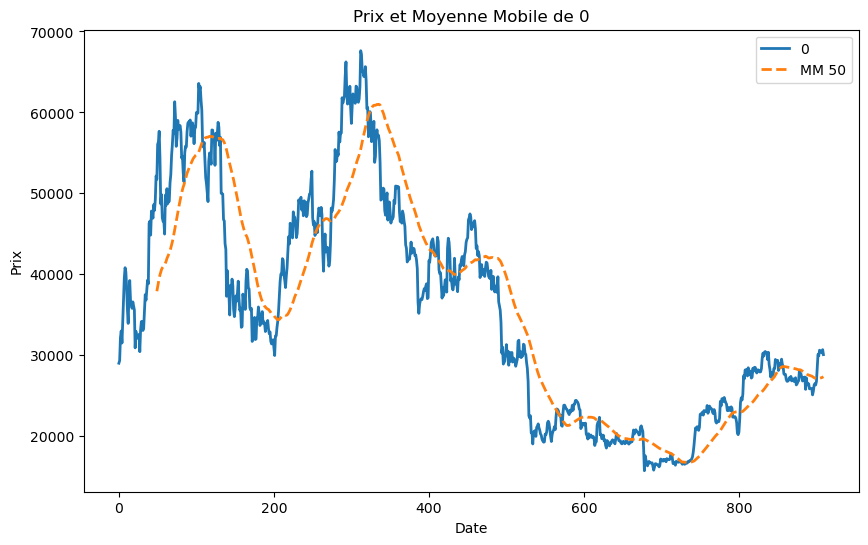

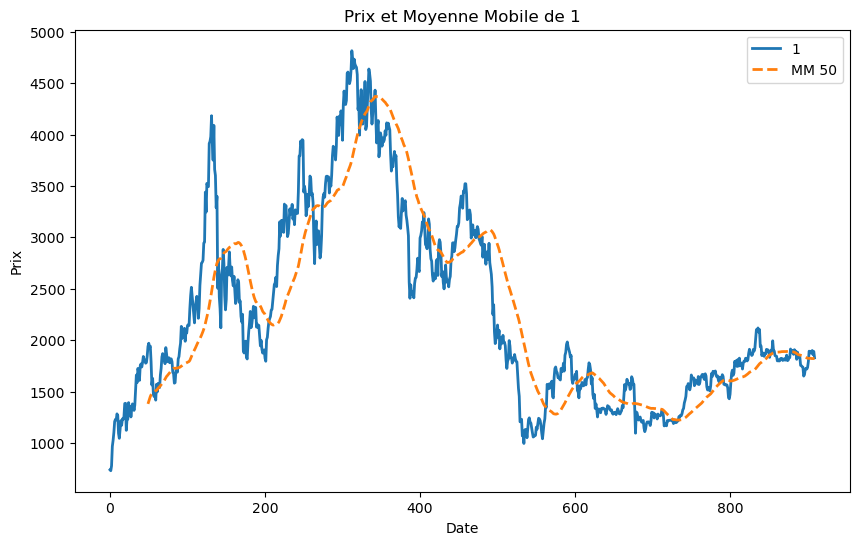

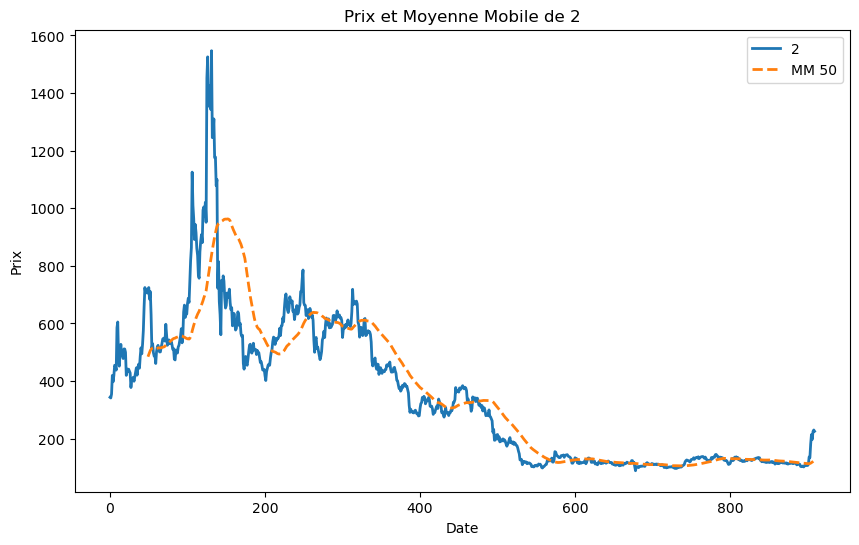

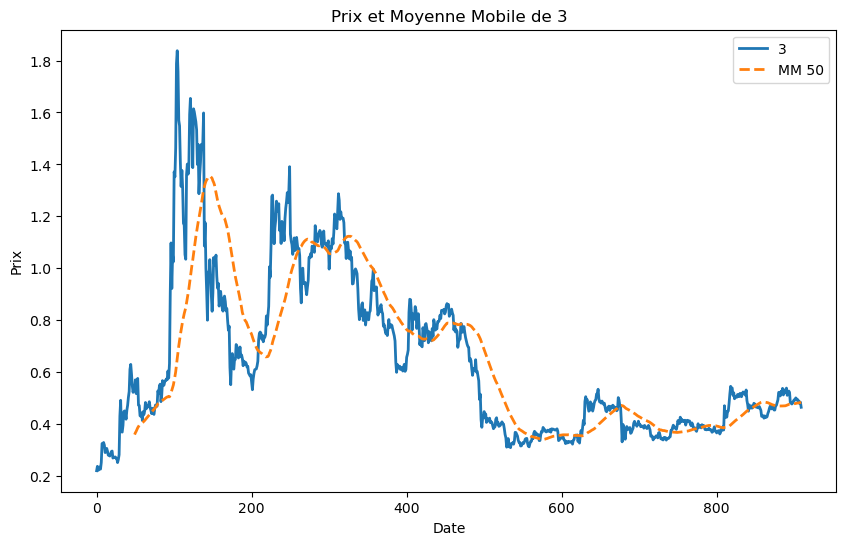

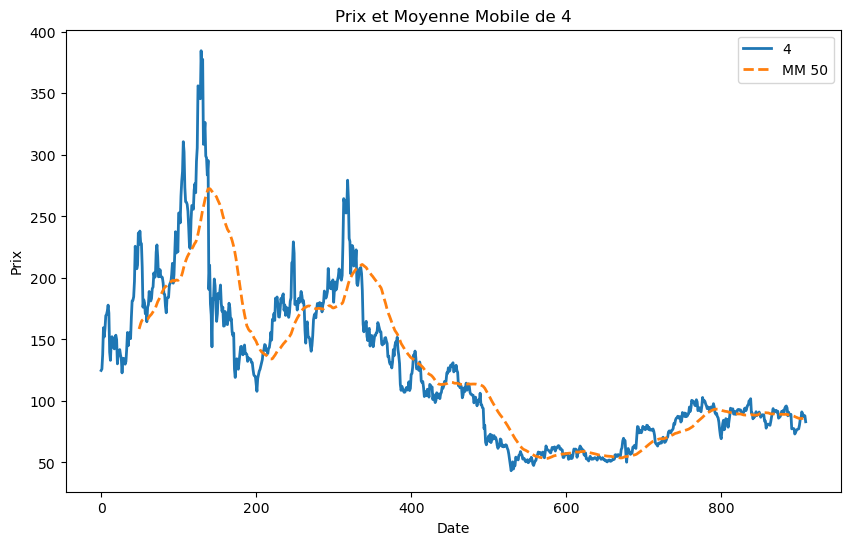

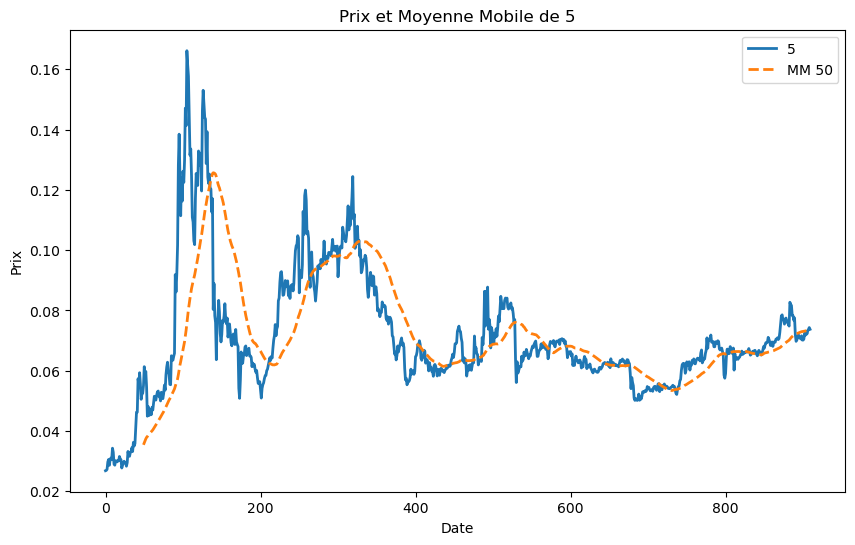

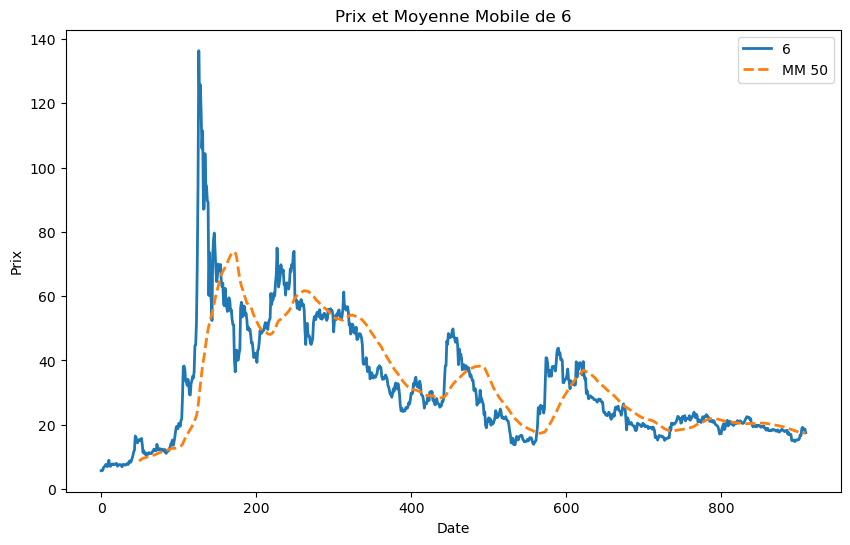

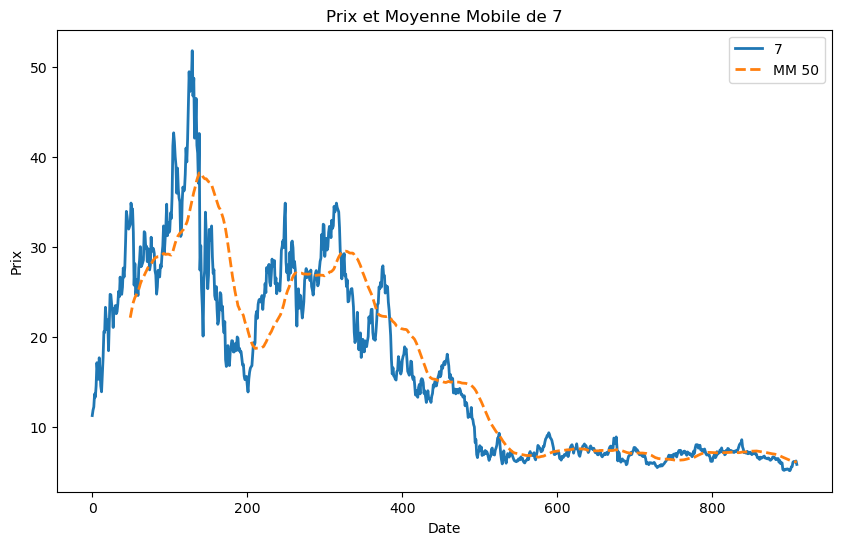

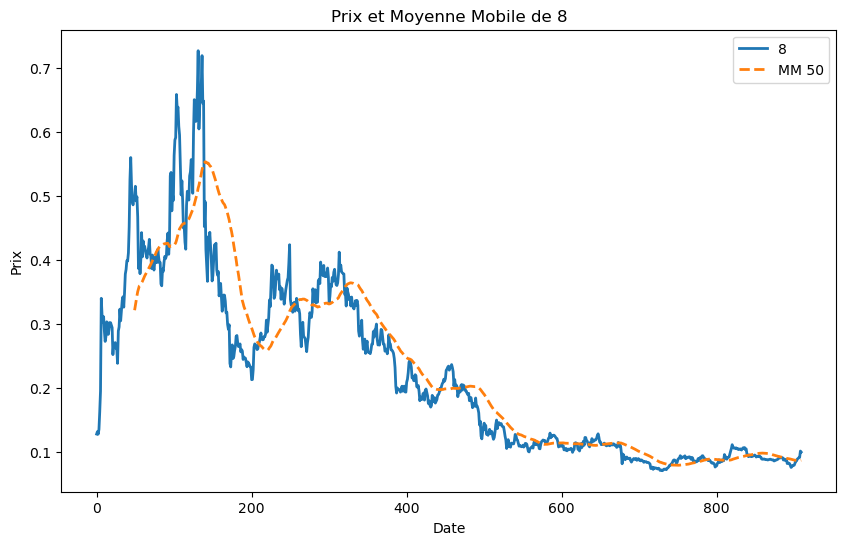

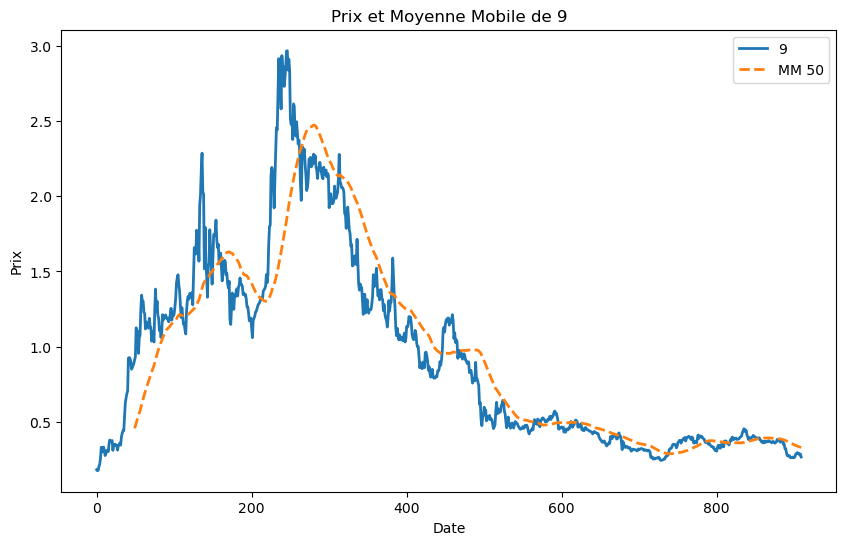

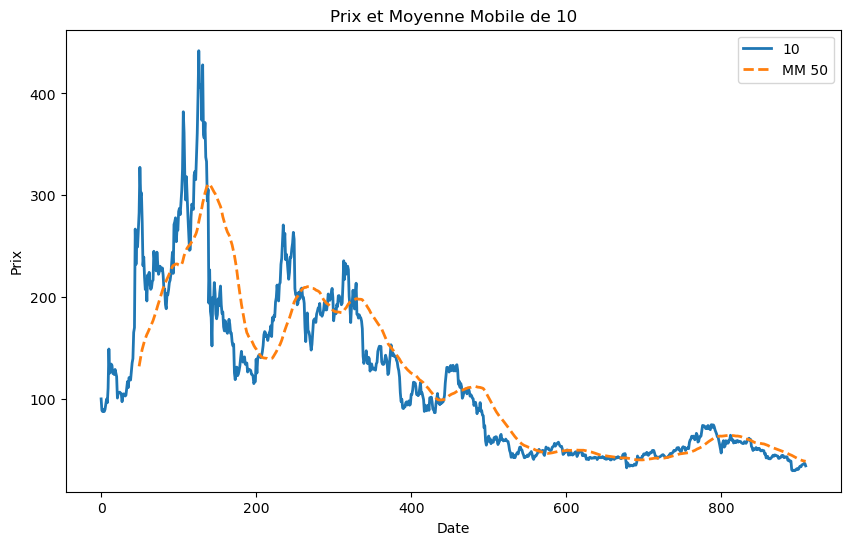

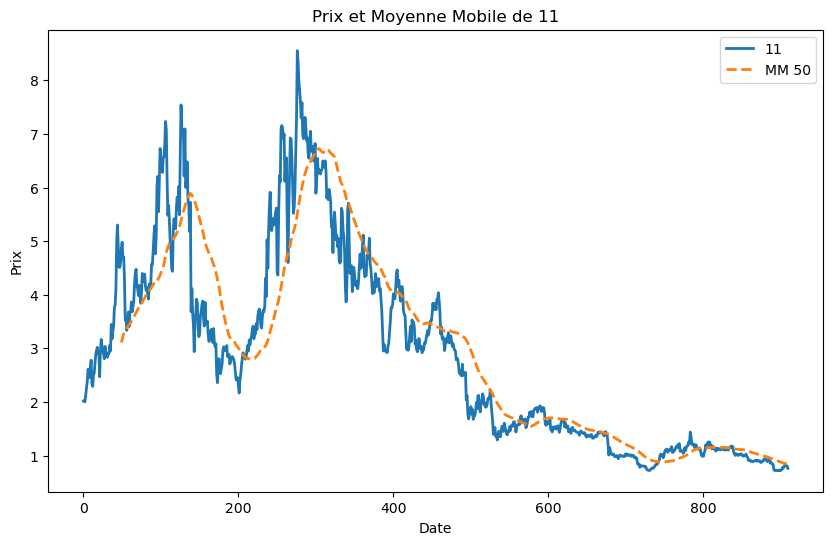

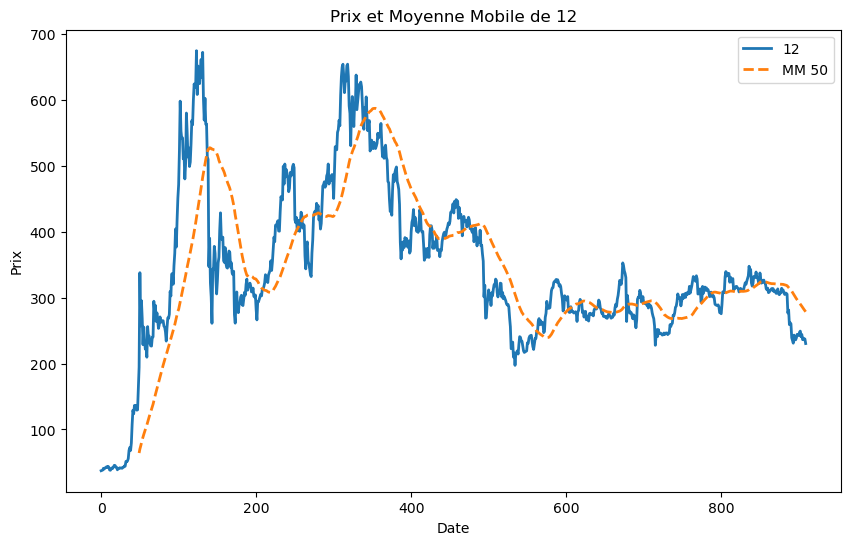

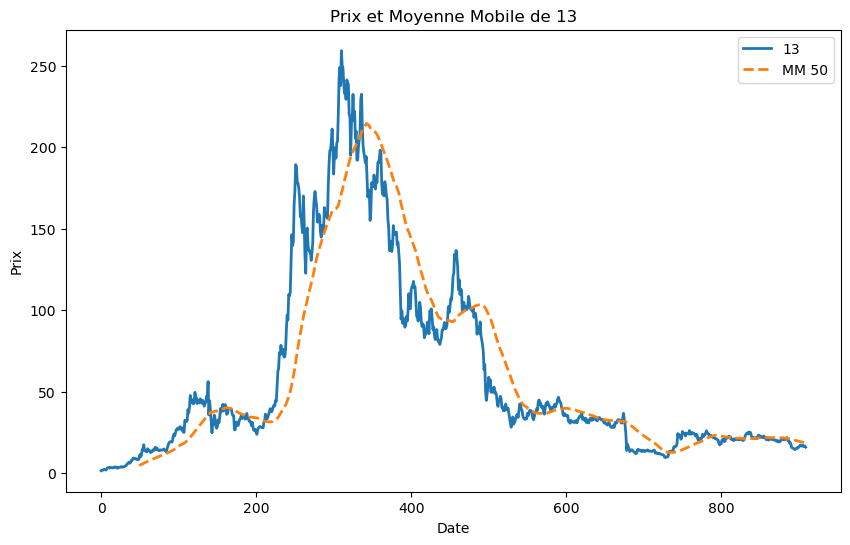

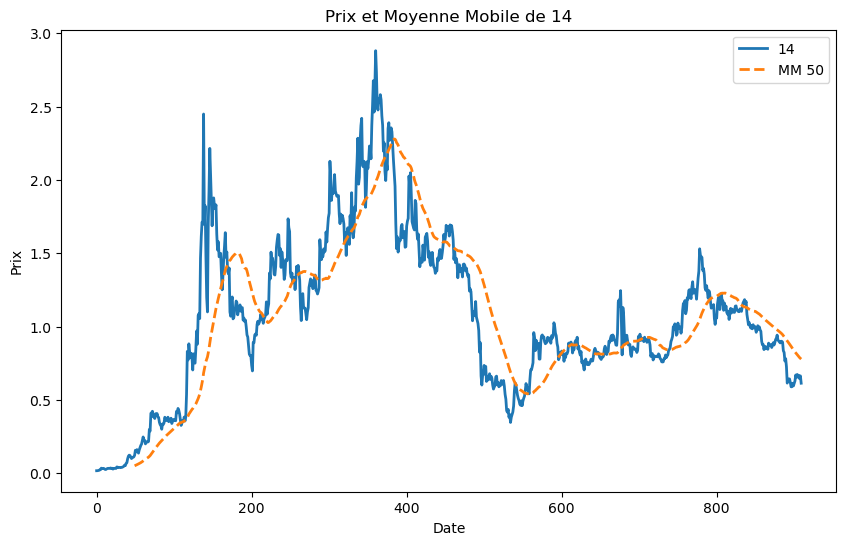

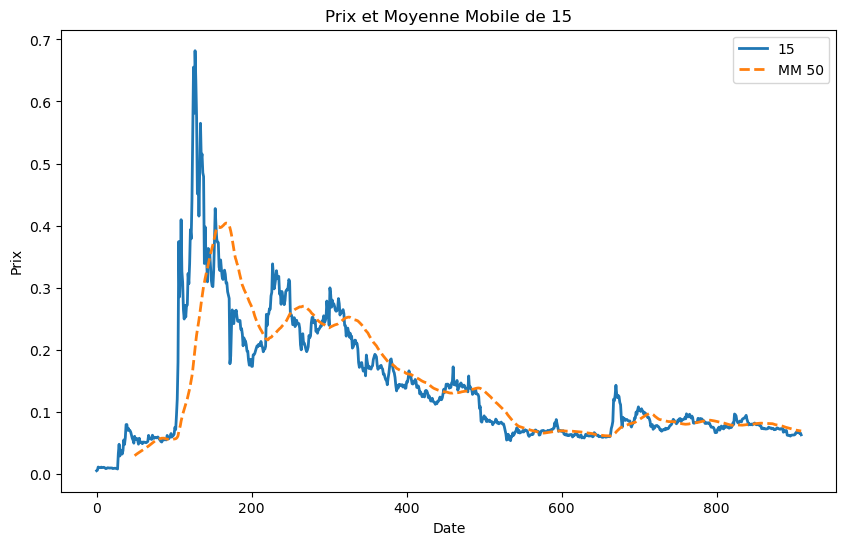

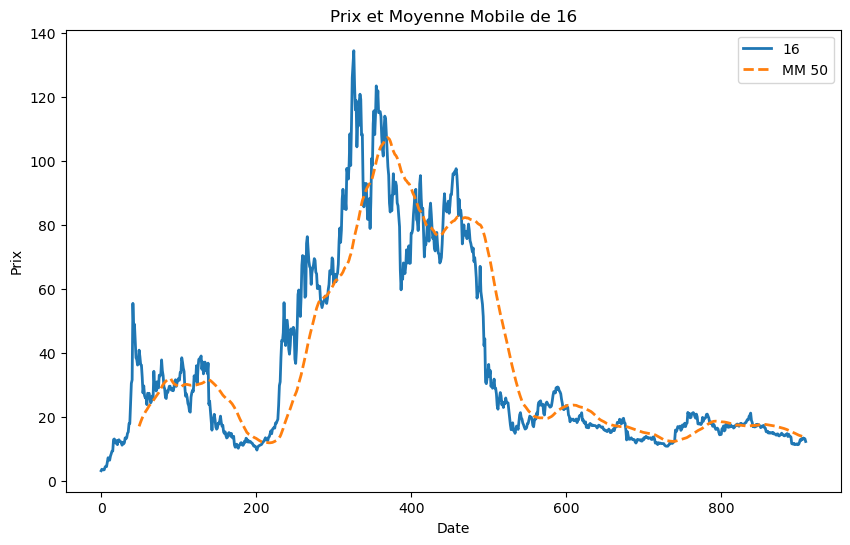

In [123]:
# Paramètres de la moyenne mobile
fenetre_moyenne_mobile = 50
Prix = pd.DataFrame(dailycryptodata)

# Boucle sur toutes les colonnes (cryptomonnaies) du DataFrame
for actif in Prix.columns:
    prix_actif = Prix[actif]
    
    # Calculer la moyenne mobile
    moyenne_mobile = prix_actif.rolling(window=fenetre_moyenne_mobile).mean()

    # Créer une figure pour chaque cryptomonnaie
    plt.figure(figsize=(10, 6))
    
    # Tracer le prix et la moyenne mobile
    plt.plot(prix_actif, label=actif, linewidth=2)
    plt.plot(moyenne_mobile, label=f'MM {fenetre_moyenne_mobile}', linestyle='--', linewidth=2)

    # Ajouter des titres et des légendes
    plt.title(f'Prix et Moyenne Mobile de {actif}')
    plt.xlabel('Date')
    plt.ylabel('Prix')
    plt.legend()
    
    # Afficher le graphique
    plt.show()

In [124]:
# Paramètres de la moyenne mobile (à ajuster selon vos besoins)
fenetre_moyenne_mobile = 50

MArdt = pd.DataFrame(prix_actif.rolling(window=fenetre_moyenne_mobile).mean())

for nom in nomsColonnes:
    rdt_actif = dfrdt[nom]
    moyenne_mobilerdt = rdt_actif.rolling(window=fenetre_moyenne_mobile).mean()
    MArdt[nom] = pd.DataFrame(moyenne_mobilerdt)
#Supression des bonnes valeurs
MArdt.dropna()

16   bitcoin  ethereum  bitcoin-cash    ripple  litecoin  \
49   17.080732  0.013159  0.019620      0.014930  0.019010  0.012920   
50   17.795327  0.013054  0.019434      0.013916  0.015589  0.011910   
51   18.449079  0.011678  0.018297      0.013889  0.018189  0.010079   
52   19.103525  0.009996  0.012300      0.008166  0.018741  0.005395   
53   19.683394  0.008701  0.008437      0.005142  0.014023  0.002947   
..         ...       ...       ...           ...       ...       ...   
904  13.988523  0.000678 -0.001226      0.011540  0.000791  0.000187   
905  13.901220  0.001056 -0.000013      0.010426  0.001243  0.001100   
906  13.837228  0.001137 -0.000377      0.013072  0.001124  0.000800   
907  13.770342  0.002055  0.000436      0.014493  0.002396  0.002437   
908  13.725989  0.001718 -0.000192      0.012347  0.001554  0.000781   

         tron  ethereum-classic  chainlink   stellar   cardano      dash  \
49   0.016537          0.019957   0.022637  0.027775  0.032683  0.023787   
50   0.015423          0.019586   0.021210  0.026295  0.037150  0.024438   
51   0.015672          0.019996   0.020619  0.027152  0.036488  0.024874   
52   0.012147          0.014979   0.016832  0.024716  0.033654  0.022439   
53   0.007709          0.010072   0.013201  0.017284  0.029479  0.019463   
..        ...               ...        ...       ...       ...       ...   
904  0.000308         -0.000472  -0.003253 -0.000861 -0.006183 -0.006561   
905  0.000760         -0.000672  -0.002427 -0.000235 -0.005281 -0.004997   
906  0.001189         -0.000229  -0.002693 -0.000096 -0.005963 -0.004790   
907  0.001671          0.000423  -0.001224  0.002583 -0.004915 -0.002878   
908  0.001308         -0.001361  -0.002275  0.002373 -0.006176 -0.004316   

        tezos  binancecoin    solana  matic-network  dogecoin  avalanche-2  
49   0.018075     0.044034  0.040425       0.043784  0.049348     0.049933  
50   0.016945     0.038309  0.033933       0.042041  0.045962     0.045885  
51   0.017068     0.040850  0.036378       0.042759  0.033502     0.046732  
52   0.014050     0.037542  0.038089       0.040574  0.033381     0.044769  
53   0.008853     0.034891  0.036681       0.035152  0.031996     0.041151  
..        ...          ...       ...            ...       ...          ...  
904 -0.004396    -0.006469 -0.006327      -0.008429 -0.003725    -0.005783  
905 -0.003598    -0.006027 -0.005191      -0.007640 -0.002853    -0.004273  
906 -0.003867    -0.006219 -0.006019      -0.008115 -0.003468    -0.004533  
907 -0.002462    -0.005581 -0.004368      -0.006095 -0.002033    -0.003105  
908 -0.003513    -0.006064 -0.005114      -0.007110 -0.003133    -0.004323  

[860 rows x 18 columns]

In [143]:
moyenne_mobilerdt = dfrdt.rolling(window=fenetre_moyenne_mobile).mean()
MArdt = pd.DataFrame(moyenne_mobilerdt)
MArdt.dropna()
# Fonction pour appliquer le style
def style_top3(MArdt):
    is_top3 = MArdt.isin(MArdt.nlargest(3))
    is_bottom3 = MArdt.isin(MArdt.nsmallest(3))
    
    styles = ['' for _ in range(len(MArdt))]
    
    for i, (top, bottom) in enumerate(zip(is_top3, is_bottom3)):
        if top:
            styles[i] = 'background-color: lightgreen' #3 meilleurs du jour
        elif bottom:
            styles[i] = 'background-color: lightcoral' #3 pires du jour

    return styles

# Appliquer le style
MArdt = MArdt.style.apply(style_top3, axis=1)

# Afficher le DataFrame stylisé
MArdt

In [130]:
# Fenêtres pour court, moyen et long terme
fenetres = {'Court Terme': 20, 'Moyen Terme': 50, 'Long Terme': 200}

# Dictionnaires pour stocker les résultats
top_momentum_actifs = {}
bottom_momentum_actifs = {}
portfolios_momentum = {}
portfolios_longshort = {}

for terme, fenetre in fenetres.items():
    # Calcul du momentum
    momentum = dfrdt.rolling(window=fenetre).mean()

    # Top et bottom 5 actifs
    top_actifs = momentum.iloc[-1].nlargest(5).index
    bottom_actifs = momentum.iloc[-1].nsmallest(5).index

    # Stocker les résultats
    top_momentum_actifs[terme] = top_actifs
    bottom_momentum_actifs[terme] = bottom_actifs

    # Portefeuille basé sur le momentum
    portfolios_momentum[terme] = pd.concat([pd.Series(1, index=top_actifs),pd.Series(-1, index=bottom_actifs)])

    # Portefeuille long-short
    portfolio_longshort = pd.concat([pd.Series(1, index=top_actifs), pd.Series(-1, index=bottom_actifs)])
    portfolios_longshort[terme] = portfolio_longshort

# Créer des DataFrames à partir des dictionnaires
df_top_momentum_actifs = pd.DataFrame(top_momentum_actifs)
df_bottom_momentum_actifs = pd.DataFrame(bottom_momentum_actifs)
df_portfolios_momentum = pd.DataFrame(portfolios_momentum)
df_portfolios_longshort = pd.DataFrame(portfolios_longshort)

# Affichage des résultats
print("Top Momentum Actifs par Terme:")
print(df_top_momentum_actifs)

print("\nBottom Momentum Actifs par Terme:")
print(df_bottom_momentum_actifs)

print("\nPortfolios Momentum par Terme:")
print(df_portfolios_momentum)

print("\nPortfolios Long-Short par Terme:")
print(df_portfolios_longshort)

Top Momentum Actifs par Terme:
        Court Terme   Moyen Terme    Long Terme
0      bitcoin-cash  bitcoin-cash  bitcoin-cash
1           stellar       stellar       bitcoin
2           bitcoin       bitcoin      ethereum
3  ethereum-classic        ripple          tron
4          ethereum          tron        ripple

Bottom Momentum Actifs par Terme:
     Court Terme    Moyen Terme     Long Terme
0  matic-network  matic-network       dogecoin
1        cardano        cardano  matic-network
2         solana    binancecoin           dash
3           dash         solana          tezos
4    binancecoin    avalanche-2    binancecoin

Portfolios Momentum par Terme:
                  Court Terme  Moyen Terme  Long Terme
avalanche-2               NaN         -1.0         NaN
binancecoin              -1.0         -1.0        -1.0
bitcoin                   1.0          1.0         1.0
bitcoin-cash              1.0          1.0         1.0
cardano                  -1.0         -1.0         NaN
da

Top Momentum Actifs par Terme
Court Terme: On observe que 'bitcoin-cash', 'stellar', et 'bitcoin' figurent parmi les cryptomonnaies avec le plus fort momentum. Cela indique qu'ils ont eu des performances relativement meilleures dans la période récente (20 jours).
Moyen Terme: 'bitcoin-cash', 'stellar', et 'bitcoin' se maintiennent comme actifs à fort momentum sur une période de 50 jours, montrant une tendance constante dans leur performance.
Long Terme: Sur 200 jours, 'bitcoin-cash' continue de montrer un fort momentum, mais 'ethereum' et 'ripple' émergent aussi comme des actifs performants.
Bottom Momentum Actifs par Terme
Court Terme: 'matic-network', 'cardano', et 'solana' sont parmi les actifs avec le pire momentum. Cela pourrait indiquer une période récente de sous-performance ou de volatilité.
Moyen Terme: 'matic-network' et 'cardano' restent en bas de la liste, indiquant une tendance négative persistante.
Long Terme: 'dogecoin', 'matic-network', et 'dash' apparaissent comme des actifs à faible momentum sur une période plus longue.
Portefeuilles Momentum
Court Terme: Les actifs sélectionnés sont principalement les mêmes que ceux identifiés comme ayant le meilleur momentum à court terme.
Moyen et Long Terme: Les portefeuilles se diversifient un peu plus, avec des actifs comme 'ripple' et 'tron' apparaissant dans le portefeuille à moyen terme et 'ethereum' conservant sa place dans le portefeuille à long terme.
Portefeuilles Long-Short
Les portefeuilles long-short montrent une combinaison d'investissements dans les actifs à fort momentum (long) et de paris contre ceux à faible momentum (short).
Sur tous les termes, 'bitcoin' et 'bitcoin-cash' sont constamment choisis pour des positions longues, tandis que 'binancecoin' et 'matic-network' apparaissent fréquemment dans des positions courtes.
Intéressant de noter, certains actifs comme 'ethereum' et 'tron' apparaissent dans des positions longues pour certains termes et sont absents dans d'autres, suggérant une variation dans leur performance relative en fonction de la période considérée.

### Analyse des Résultats

#### Top Momentum Actifs par Terme
- **Court Terme**: 'bitcoin-cash', 'stellar', et 'bitcoin' montrent un momentum élevé, indiquant des performances supérieures récentes.
- **Moyen Terme**: Les mêmes actifs ('bitcoin-cash', 'stellar', 'bitcoin') continuent d'afficher un fort momentum.
- **Long Terme**: 'bitcoin-cash' reste en tête, avec 'ethereum' et 'ripple' montrant également une bonne performance.

#### Bottom Momentum Actifs par Terme
- **Court Terme**: 'matic-network', 'cardano', et 'solana' affichent le pire momentum.
- **Moyen Terme**: 'matic-network' et 'cardano' maintiennent une tendance négative.
- **Long Terme**: 'dogecoin', 'matic-network', et 'dash' émergent comme les actifs les moins performants.

#### Portefeuilles Momentum
- **Court Terme**: Principalement composé d'actifs ayant le meilleur momentum à court terme.
- **Moyen et Long Terme**: Plus de diversification avec 'ripple' et 'tron' apparaissant à moyen terme, et 'ethereum' restant à long terme.

#### Portefeuilles Long-Short
- Positions longues constantes sur 'bitcoin' et 'bitcoin-cash', tandis que 'binancecoin' et 'matic-network' apparaissent souvent en short.
- Variabilité dans la performance relative de certains actifs comme 'ethereum' et 'tron' selon la période.

### Implications pour la Stratégie d'Investissement
- **Diversification Temporelle**: L'importance d'examiner des horizons temporels variés dans la construction de portefeuilles.
- **Surveillance des Tendances**: 'bitcoin-cash' et 'bitcoin' montrent une tendance haussière constante, alors que 'matic-network' indique une tendance baissière.
- **Stratégie de Trading**: Une approche équilibrée pourrait être d'investir long sur les actifs à momentum positif et court sur ceux à momentum négatif pour gérer les risques.
